In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.style.use('./paper.mcstyle')

import pandas as pd
from sklearn.neighbors import NearestNeighbors

from multiprocessing import cpu_count
from multiprocessing import Pool


import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

import CASBI

# Initial test

3778
51519.293494715705


(array([2712.,  312.,  211.,  129.,  134.,  103.,   63.,   43.,   44.,
          27.]),
 array([5.15192935e+04, 1.39574865e+08, 2.79098210e+08, 4.18621555e+08,
        5.58144901e+08, 6.97668246e+08, 8.37191591e+08, 9.76714937e+08,
        1.11623828e+09, 1.25576163e+09, 1.39528497e+09]),
 <BarContainer object of 10 artists>)

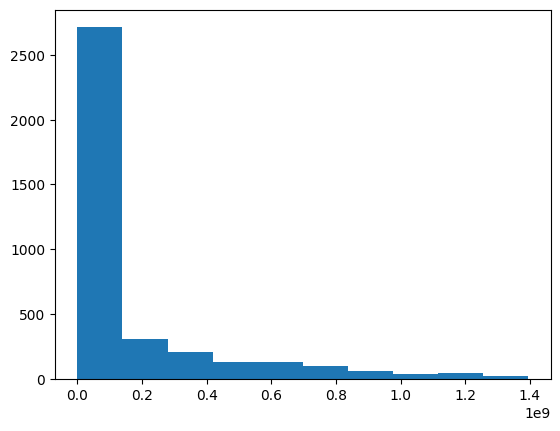

In [2]:
data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
data['star_log10mass'] = 10**data['star_log10mass']
data_mass = data['star_log10mass'].drop_duplicates()
data_mass = data_mass[data_mass<1.4*1e9]
print(len(data_mass))
print(data_mass.min())
plt.hist(data_mass)

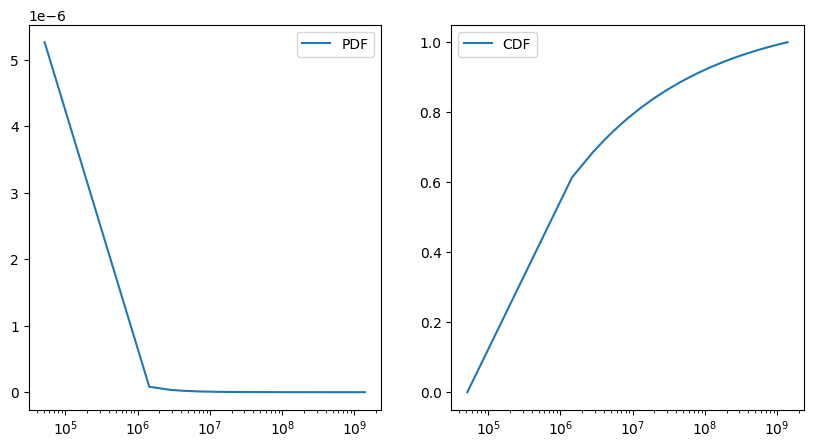

In [3]:
m_min, m_max = data_mass.min(), data_mass.max()
alpha = 1.25
def pdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* m**(-alpha)
def cdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* (1/(1-alpha)) * (m**(1-alpha) - m_min**(1-alpha))

mass =  np.linspace(m_min, m_max, 1000 )
fig =  plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(mass, pdf(mass, alpha), label='PDF')
ax.set_xscale('log')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(mass, cdf(mass, alpha), label='CDF')
ax.set_xscale('log')
ax.legend()

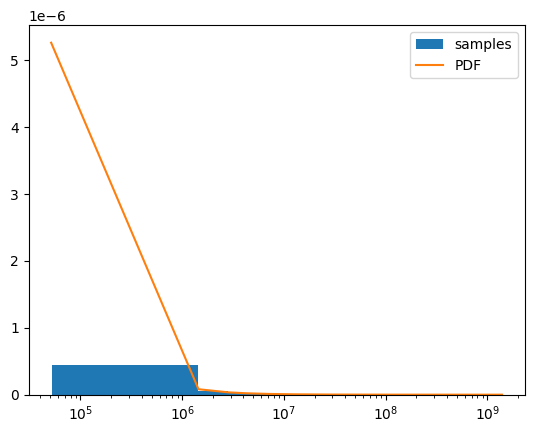

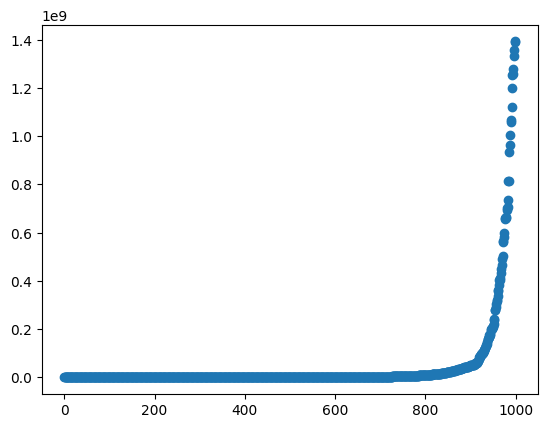

In [4]:
def inverse_cdf(y, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (y*norm_const*(1-alpha) + m_min**(1-alpha))**(1/(1-alpha))

samples = inverse_cdf(np.random.rand(1_000), alpha, )
plt.hist(samples, density=True, bins=1000, label='samples')
plt.plot(mass, pdf(mass, alpha), label='PDF',)
plt.xscale('log')
plt.legend()
plt.show()

plt.scatter(range(samples.shape[0]), sorted(samples))


In [59]:
import numpy as np

# Assuming mass_series is your series of mass values
mass_nn = data_mass.values.reshape(-1, 1)

x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

# Number of neighbors you want to find
N = 2

# Create a NearestNeighbors object
nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

# Find the N nearest neighbors of x
distances, indices = nbrs.kneighbors(x)

# # Print the nearest neighbors for each value in x
# for i, value in enumerate(x.flatten()):
#     print(f"The {N} nearest neighbors of {value} are: {mass_nn[indices[i]].flatten()}")

In [60]:
sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]

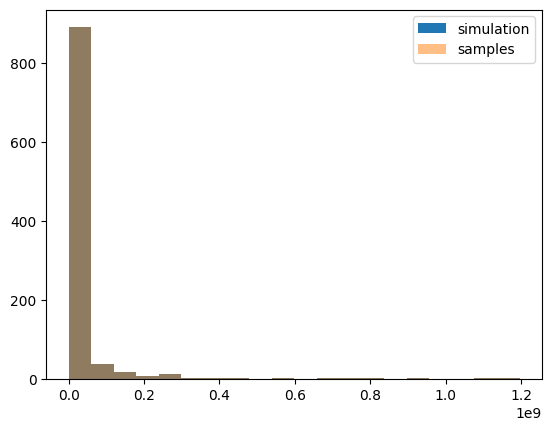

In [61]:
plt.hist(sim_mass, bins=20, label='simulation')
plt.hist(samples, bins=20, alpha=0.5, label='samples')
plt.legend()

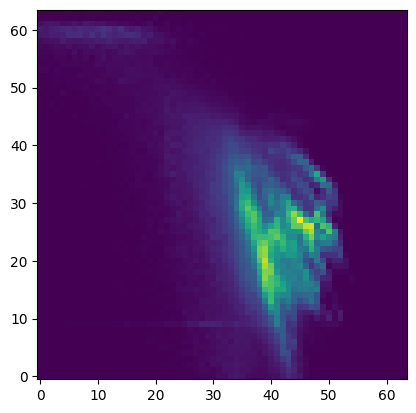

In [62]:
hist = np.sum( np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ]), axis=0)
plt.imshow(hist.T, origin='lower')

In [70]:
def gen_real_halo(j):
    np.random.seed(j)
    samples = inverse_cdf(np.random.rand(100), alpha, )
    # Assuming mass_series is your series of mass values
    mass_nn = data_mass.values.reshape(-1, 1)

    x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

    # Number of neighbors you want to find
    N = 2

    # Create a NearestNeighbors object
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

    # Find the N nearest neighbors of x
    distances, indices = nbrs.kneighbors(x)
    sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]
    
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ])
    hist = np.sum( arr, axis=0)
    return hist, np.sum(np.array(sim_mass))
    

In [71]:
from multiprocessing import Pool

with Pool() as p:
    result = p.map(gen_real_halo, range(50) )

hist_list, sim_mass_list = zip(*result)

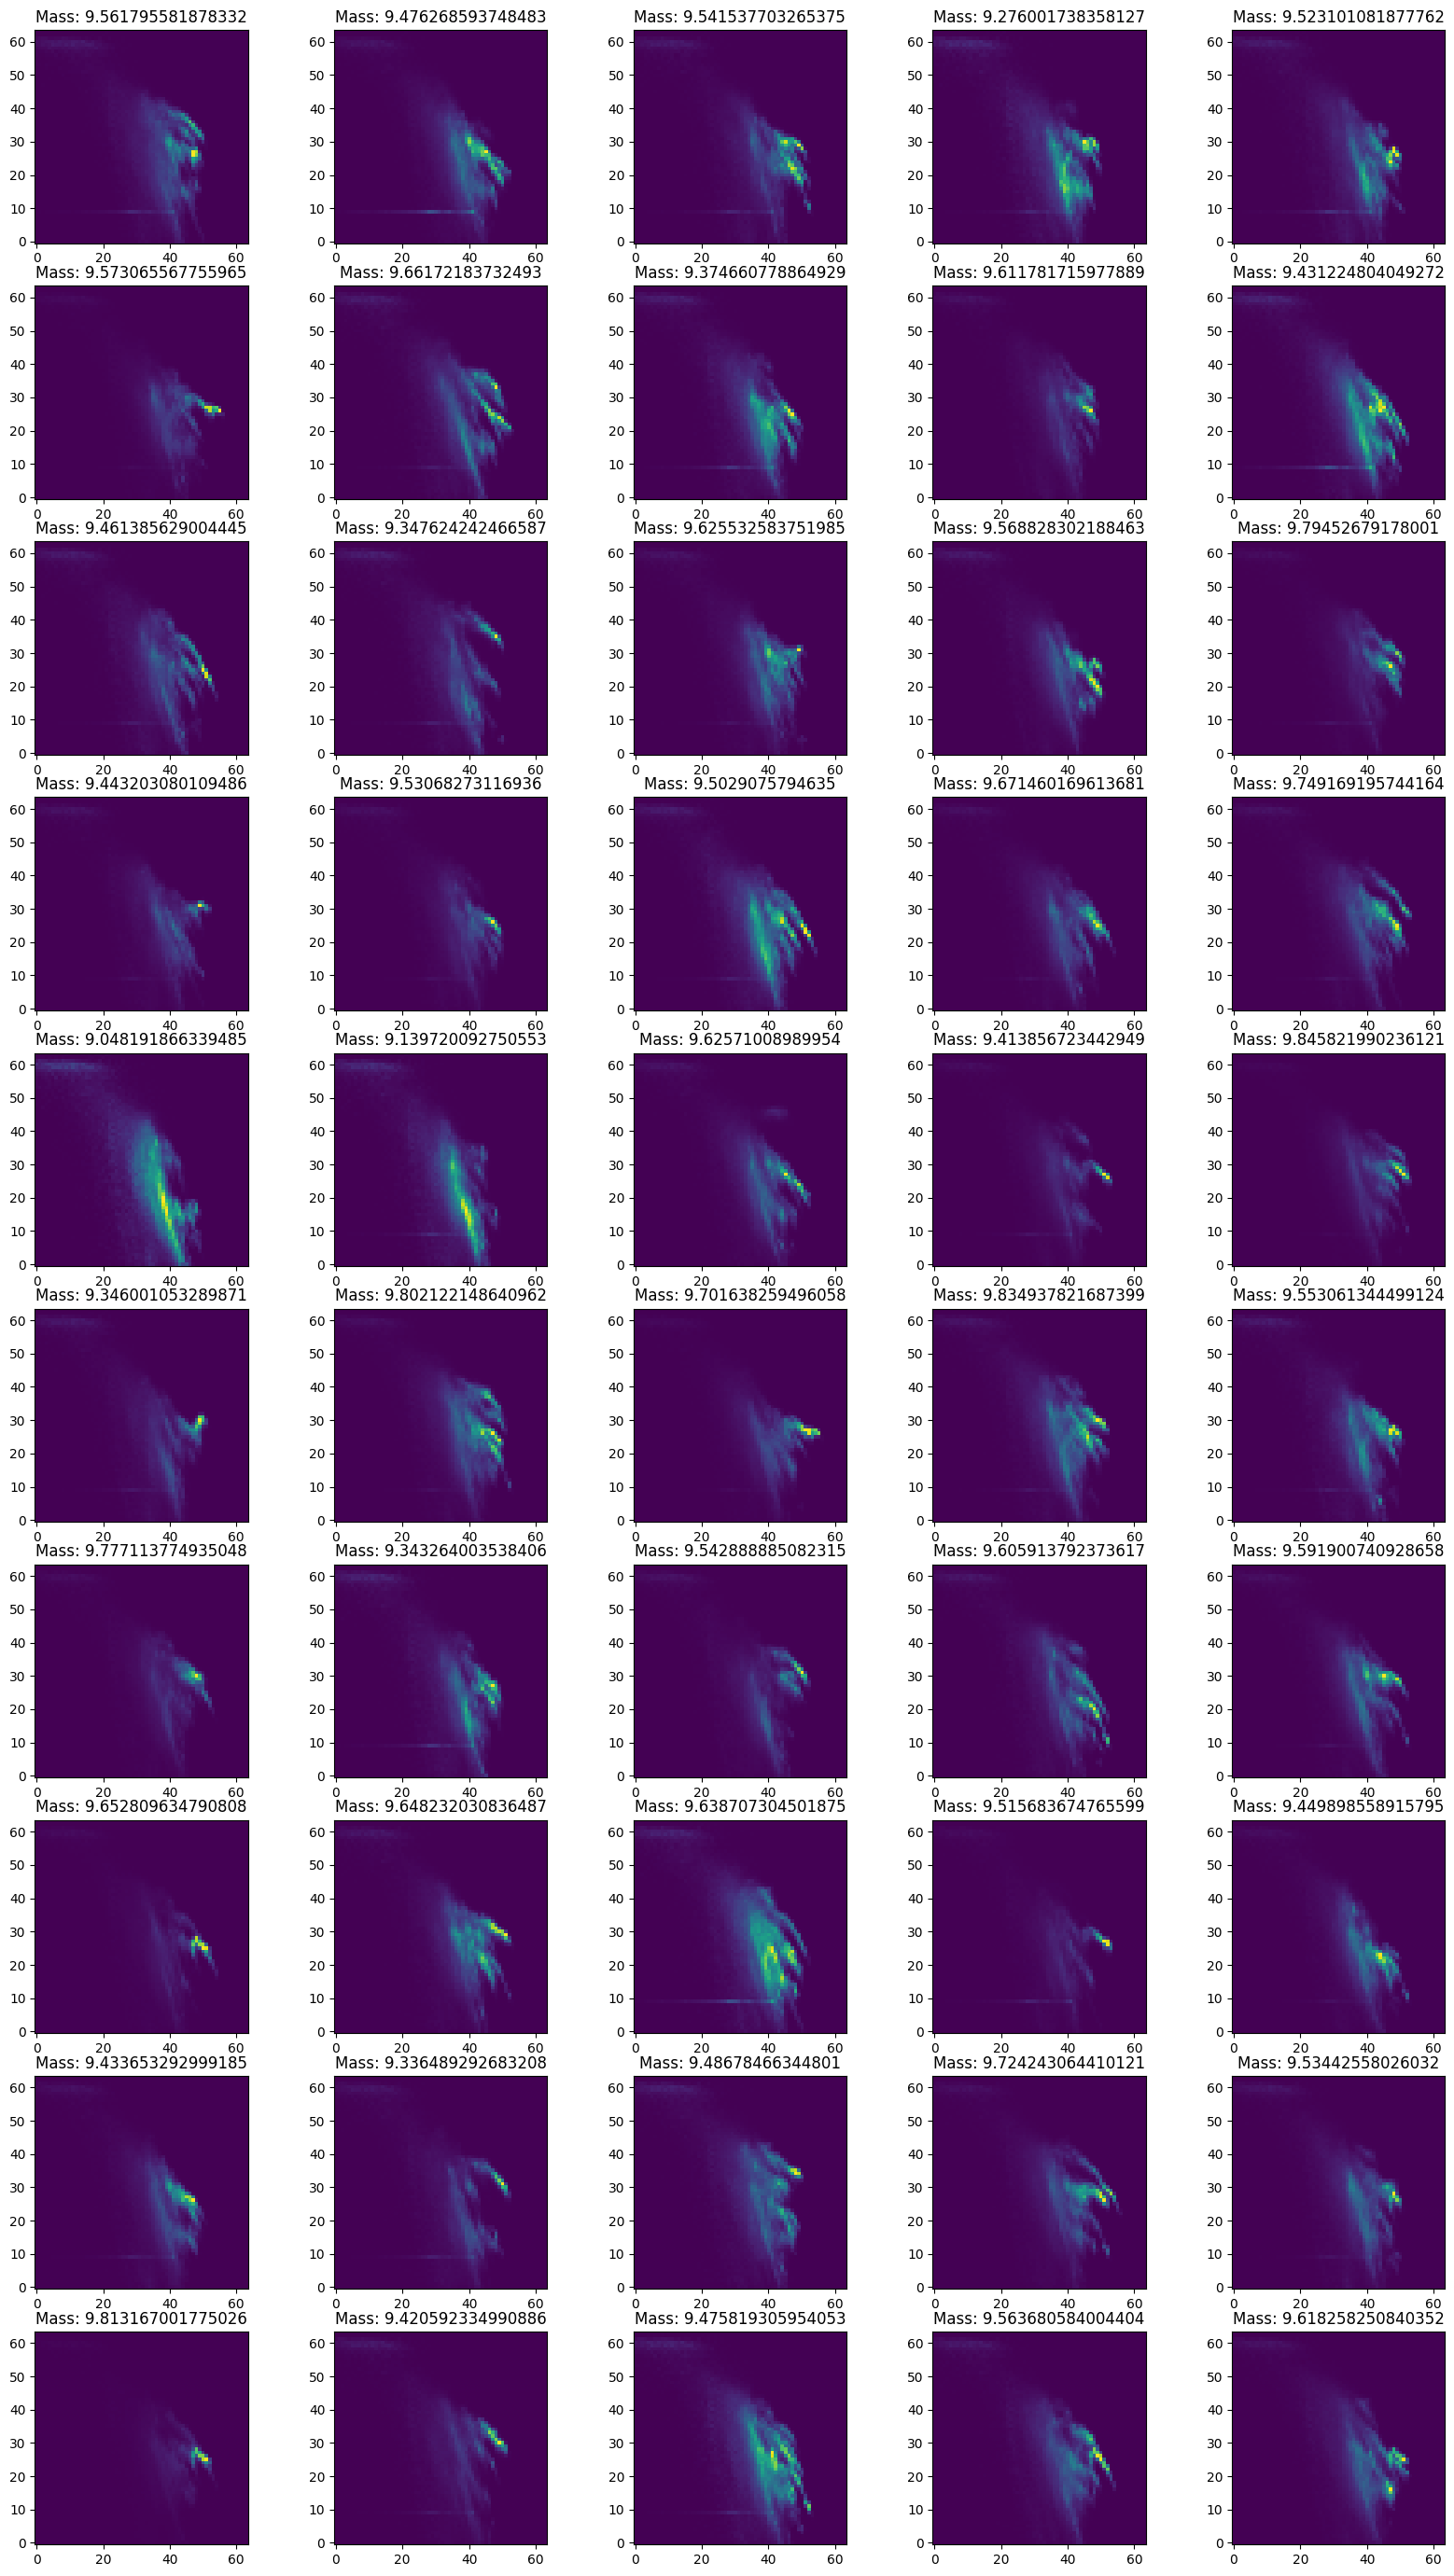

In [73]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower', )
    ax.set_title(f'Mass: {np.log10(sim_mass_list[i])}')

(array([2., 5., 7., 9., 9., 8., 2., 2., 3., 3.]),
 array([1.11735677e+09, 1.70678894e+09, 2.29622111e+09, 2.88565327e+09,
        3.47508544e+09, 4.06451760e+09, 4.65394977e+09, 5.24338193e+09,
        5.83281410e+09, 6.42224626e+09, 7.01167843e+09]),
 <BarContainer object of 10 artists>)

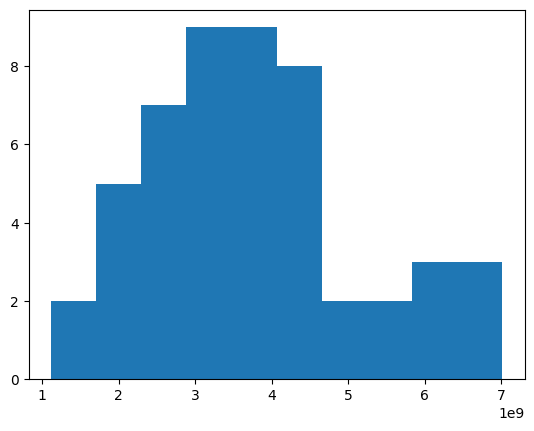

In [74]:
plt.hist(sim_mass_list)

## More realistic halo with a total mass budget and first sample than NN

In [150]:
def gen_real_halo(j):
    np.random.seed(j)
    M_tot = 1.8 * 1e9
    samples = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > data_mass.max():
            samples.append(inverse_cdf(np.random.rand(1), alpha, ))
            M_tot = M_tot - samples[-1]
        else:
            if M_tot < data_mass.min():
                break
            max_u = cdf(M_tot, alpha)
            samples.append(inverse_cdf(np.random.uniform(0, max_u), alpha, ))
            M_tot = M_tot - samples[-1]
        iteration += 1 
        
    # Assuming mass_series is your series of mass values
    mass_nn = data_mass.values.reshape(-1, 1)

    samples =  np.array(samples)
    x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

    # Number of neighbors you want to find
    N = 2

    # Create a NearestNeighbors object
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

    # Find the N nearest neighbors of x
    distances, indices = nbrs.kneighbors(x)
    sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]
    
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ])
    hist = np.sum( arr, axis=0)
    return hist, sim_mass, samples

In [124]:
hist, sim, samples = gen_real_halo(0)

M_tot 1400000000.0
M_tot [1.39913468e+09]
M_tot [1.39530476e+09]
M_tot [1.39398174e+09]
max_u [0.99998025]
M_tot [1.39314142e+09]
max_u [0.9999675]
M_tot [1.39276782e+09]
max_u [0.99996183]
M_tot [1.39084299e+09]
max_u [0.99993258]
M_tot [1.39043619e+09]
max_u [0.99992639]
M_tot [1.3388879e+09]
max_u [0.99912345]
M_tot [1.01421219e+09]
max_u [0.99298194]
M_tot [1.01392167e+09]
max_u [0.99297538]
M_tot [1.00492908e+09]
max_u [0.99277122]
M_tot [1.00420156e+09]
max_u [0.9927546]
M_tot [1.00323129e+09]
max_u [0.99273241]
M_tot [9.08617255e+08]
max_u [0.99043042]
M_tot [9.08549882e+08]
max_u [0.99042867]
M_tot [9.08478102e+08]
max_u [0.99042682]
M_tot [9.08422595e+08]
max_u [0.99042538]
M_tot [8.92799446e+08]
max_u [0.99001631]
M_tot [8.8548159e+08]
max_u [0.98982162]
M_tot [8.56857131e+08]
max_u [0.98904027]
M_tot [4.71885311e+08]
max_u [0.97368087]
M_tot [4.63799831e+08]
max_u [0.97320084]
M_tot [4.63362627e+08]
max_u [0.97317458]
M_tot [4.56969928e+08]
max_u [0.97278712]
M_tot [4.568892

Text(0.5, 1.0, '1.40e+00 1e9')

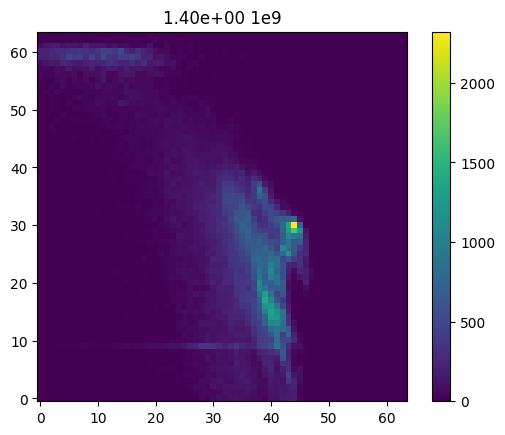

In [126]:
plt.imshow(hist.T, origin='lower')
plt.colorbar()
plt.title(f'{np.sum(sim)/1e9:.2e} 1e9')

### Outlier detection

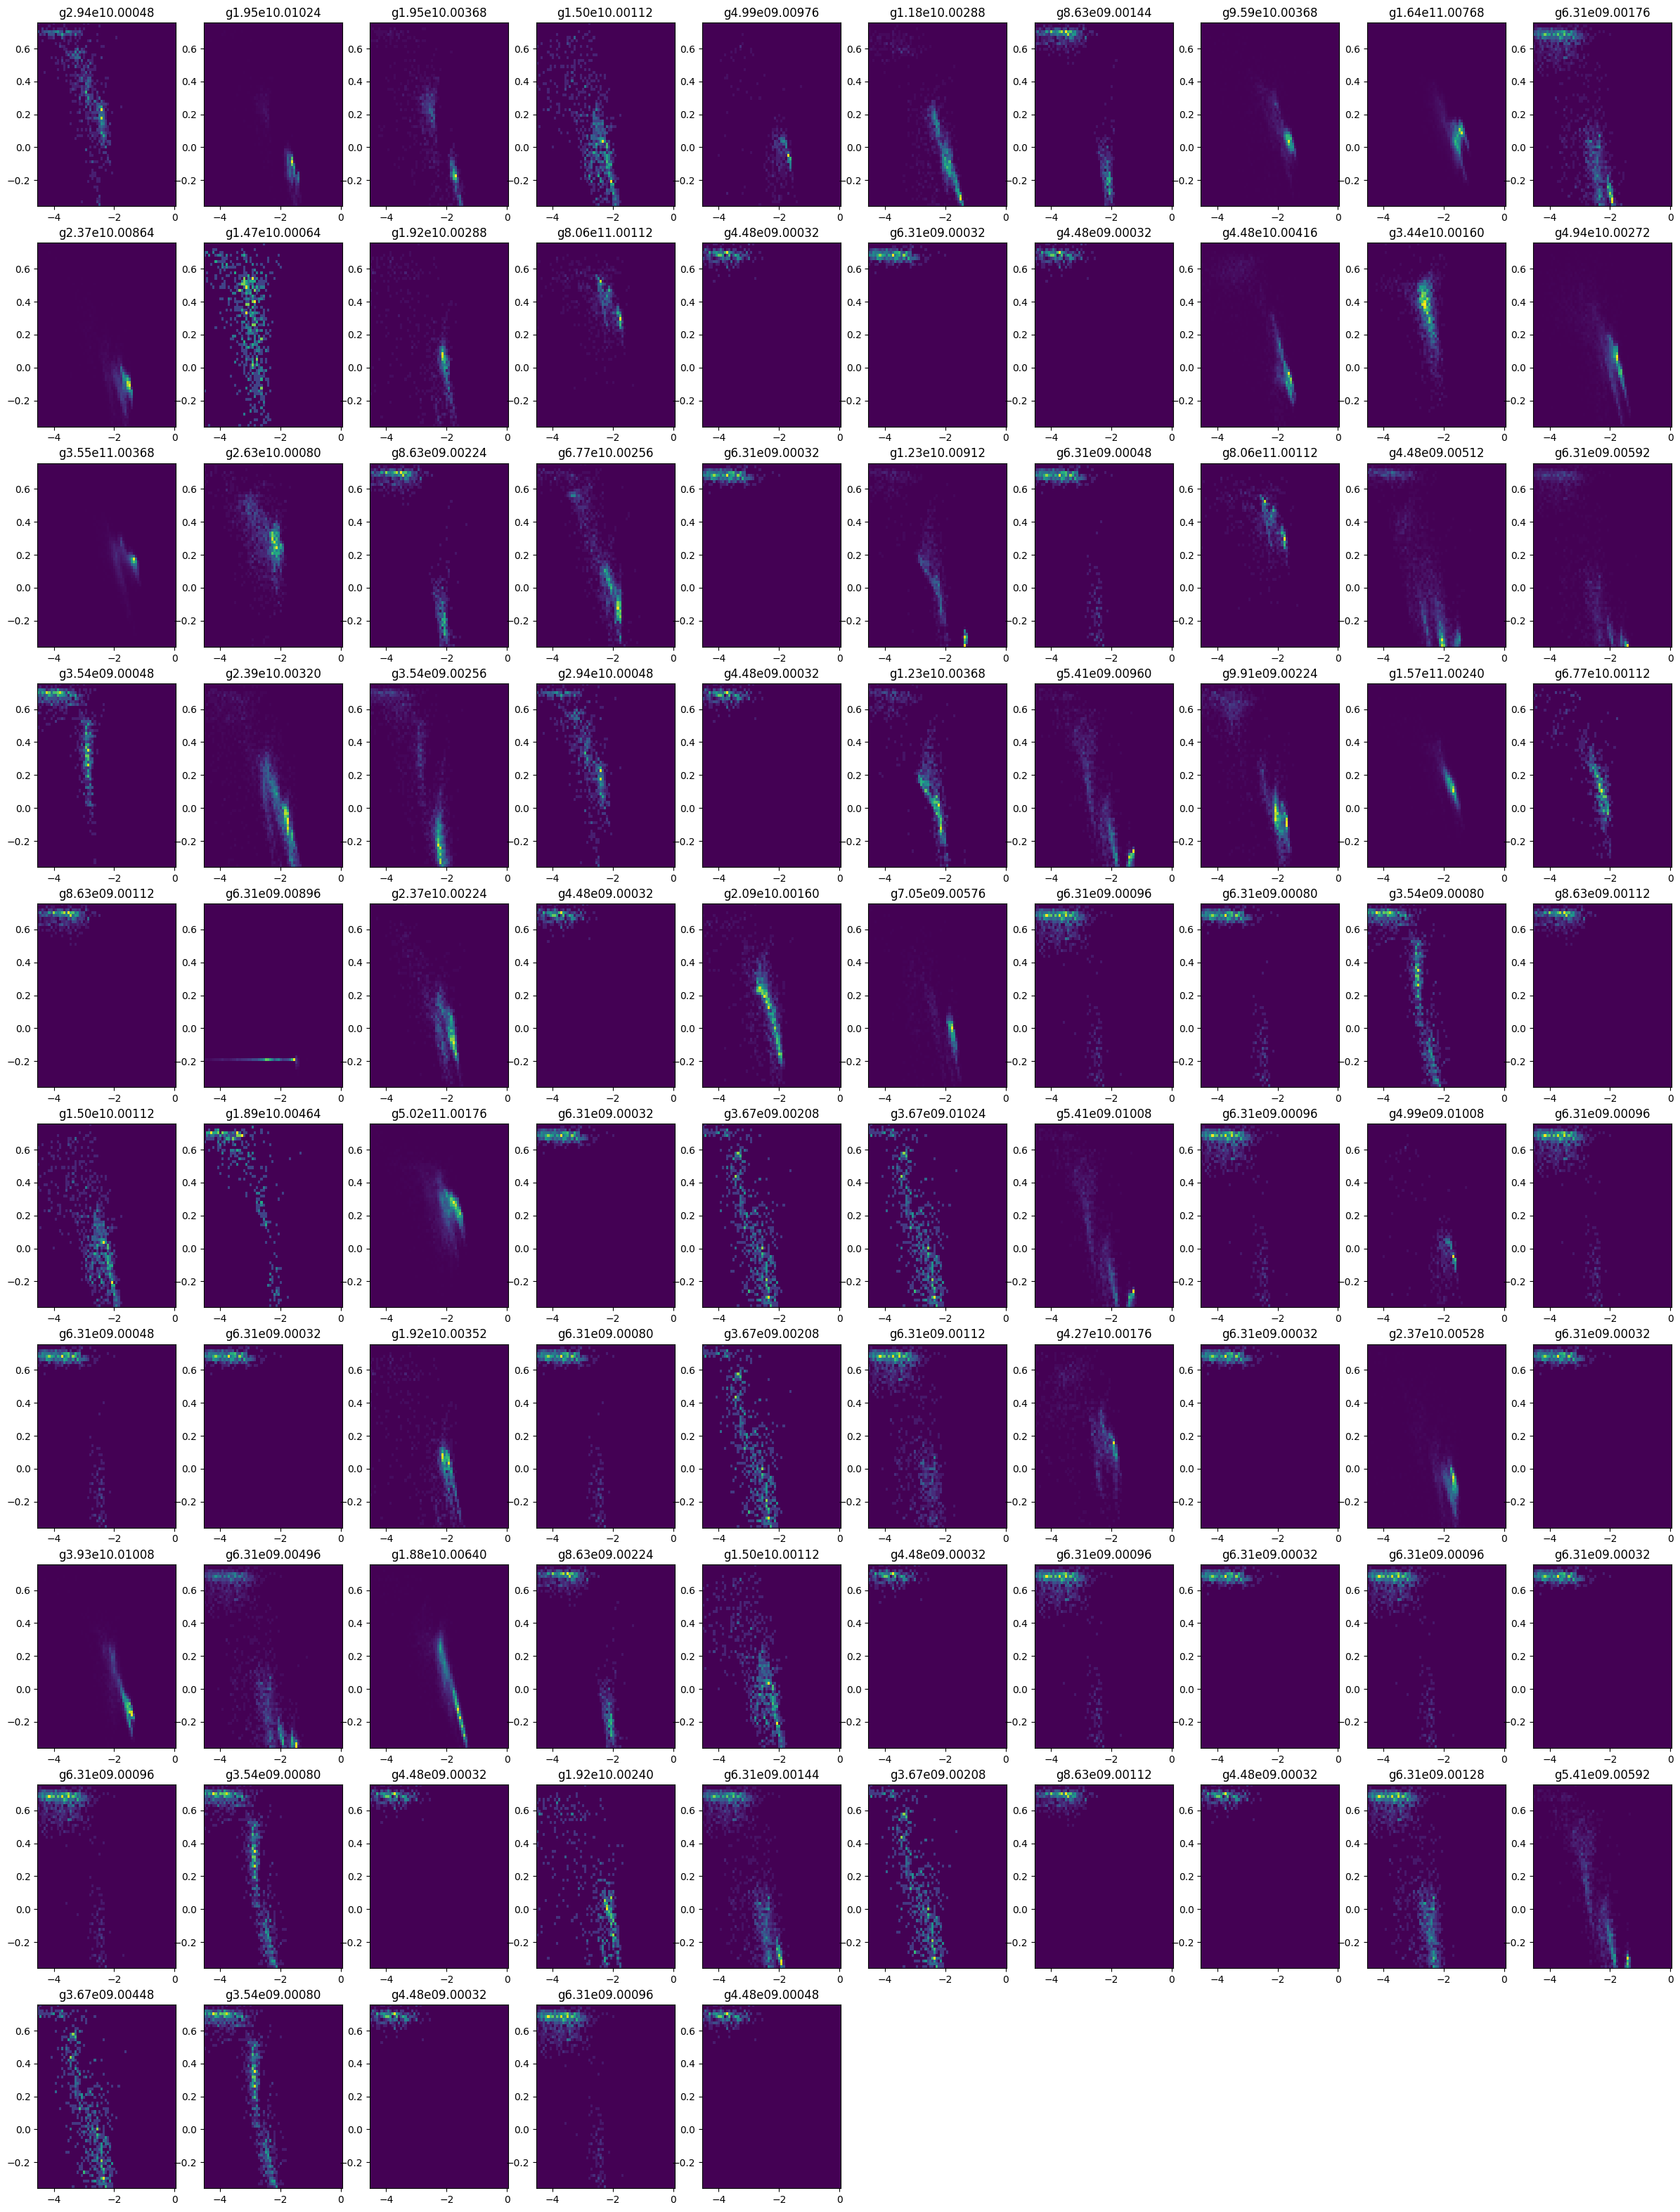

In [141]:
arr = np.array([data[data["star_log10mass"] == s]["Galaxy_name"].values[0]  for s in sim ])
fig = plt.figure(figsize=(30, 40))
min_feh, max_feh = data['feh'].min(), data['feh'].max()
min_ofe, max_ofe = data['ofe'].min(), data['ofe'].max()
for i, name in enumerate(arr):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{name}'+'.npz' )['observables'].T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(name)

## Create 50 halos

In [151]:
from multiprocessing import Pool

with Pool() as p:
    result = p.map(gen_real_halo, range(50) )

hist_list, sim_mass_list, samples = zip(*result)

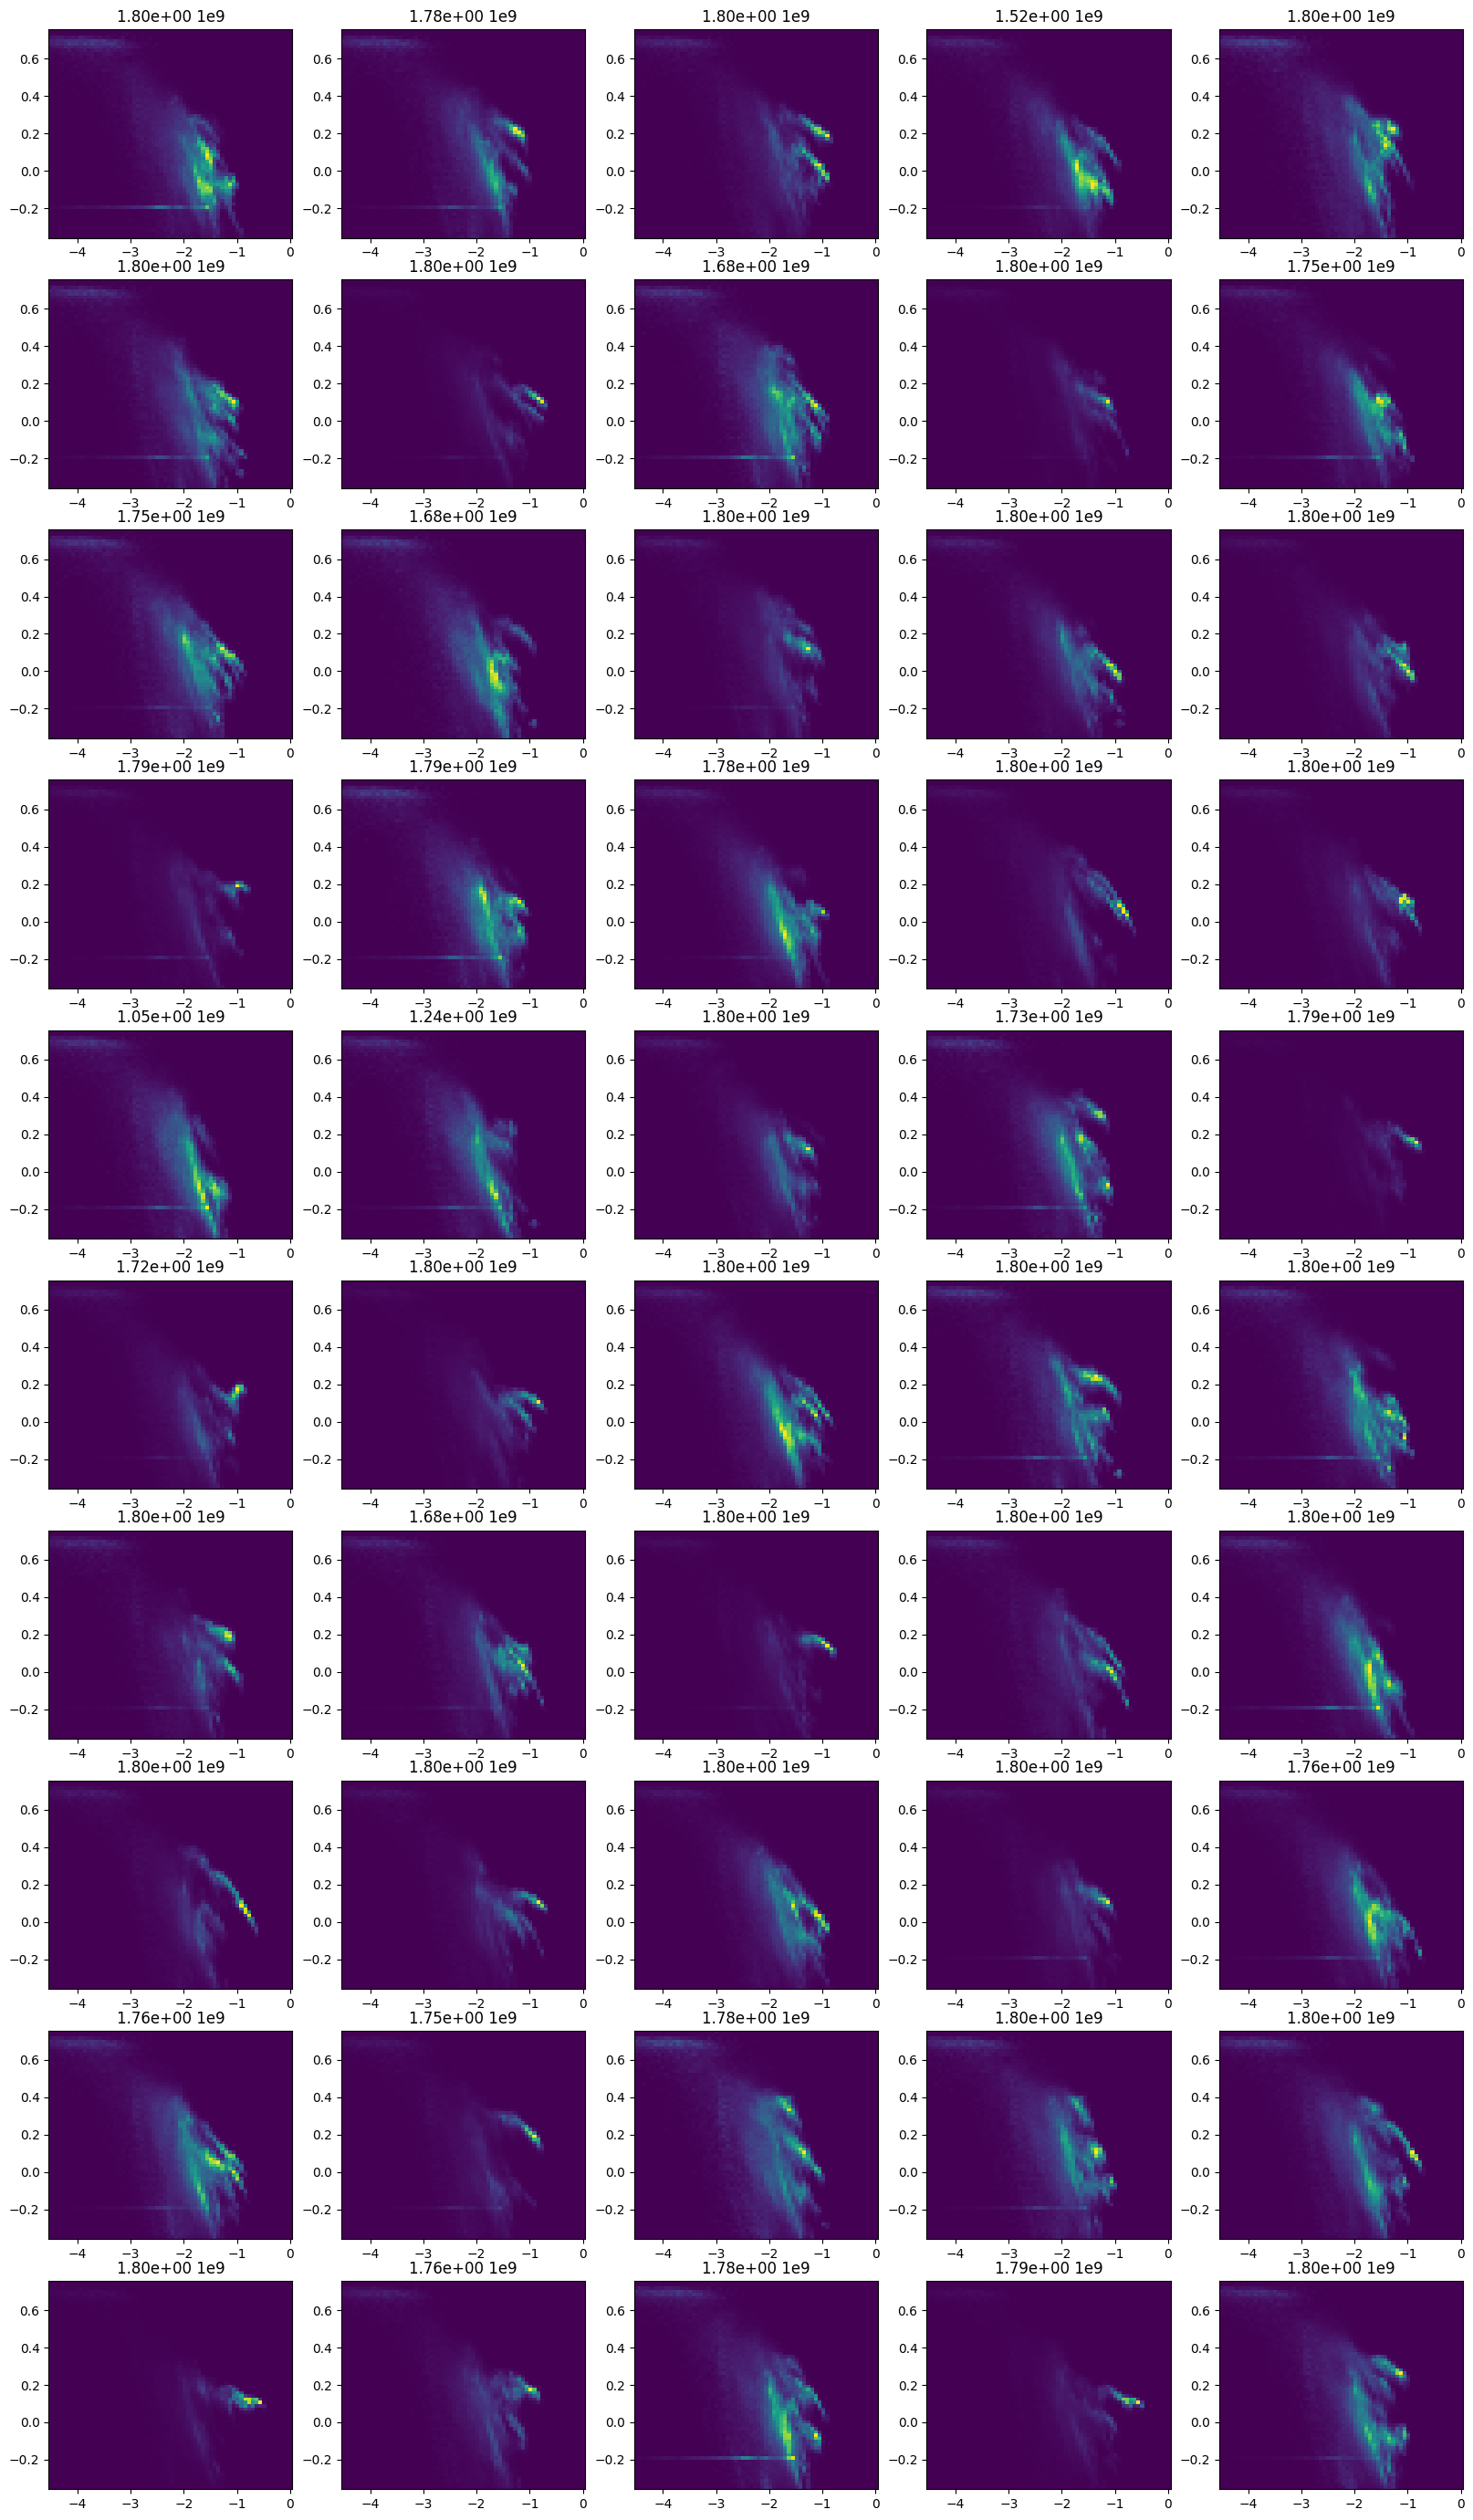

In [152]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower',extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    

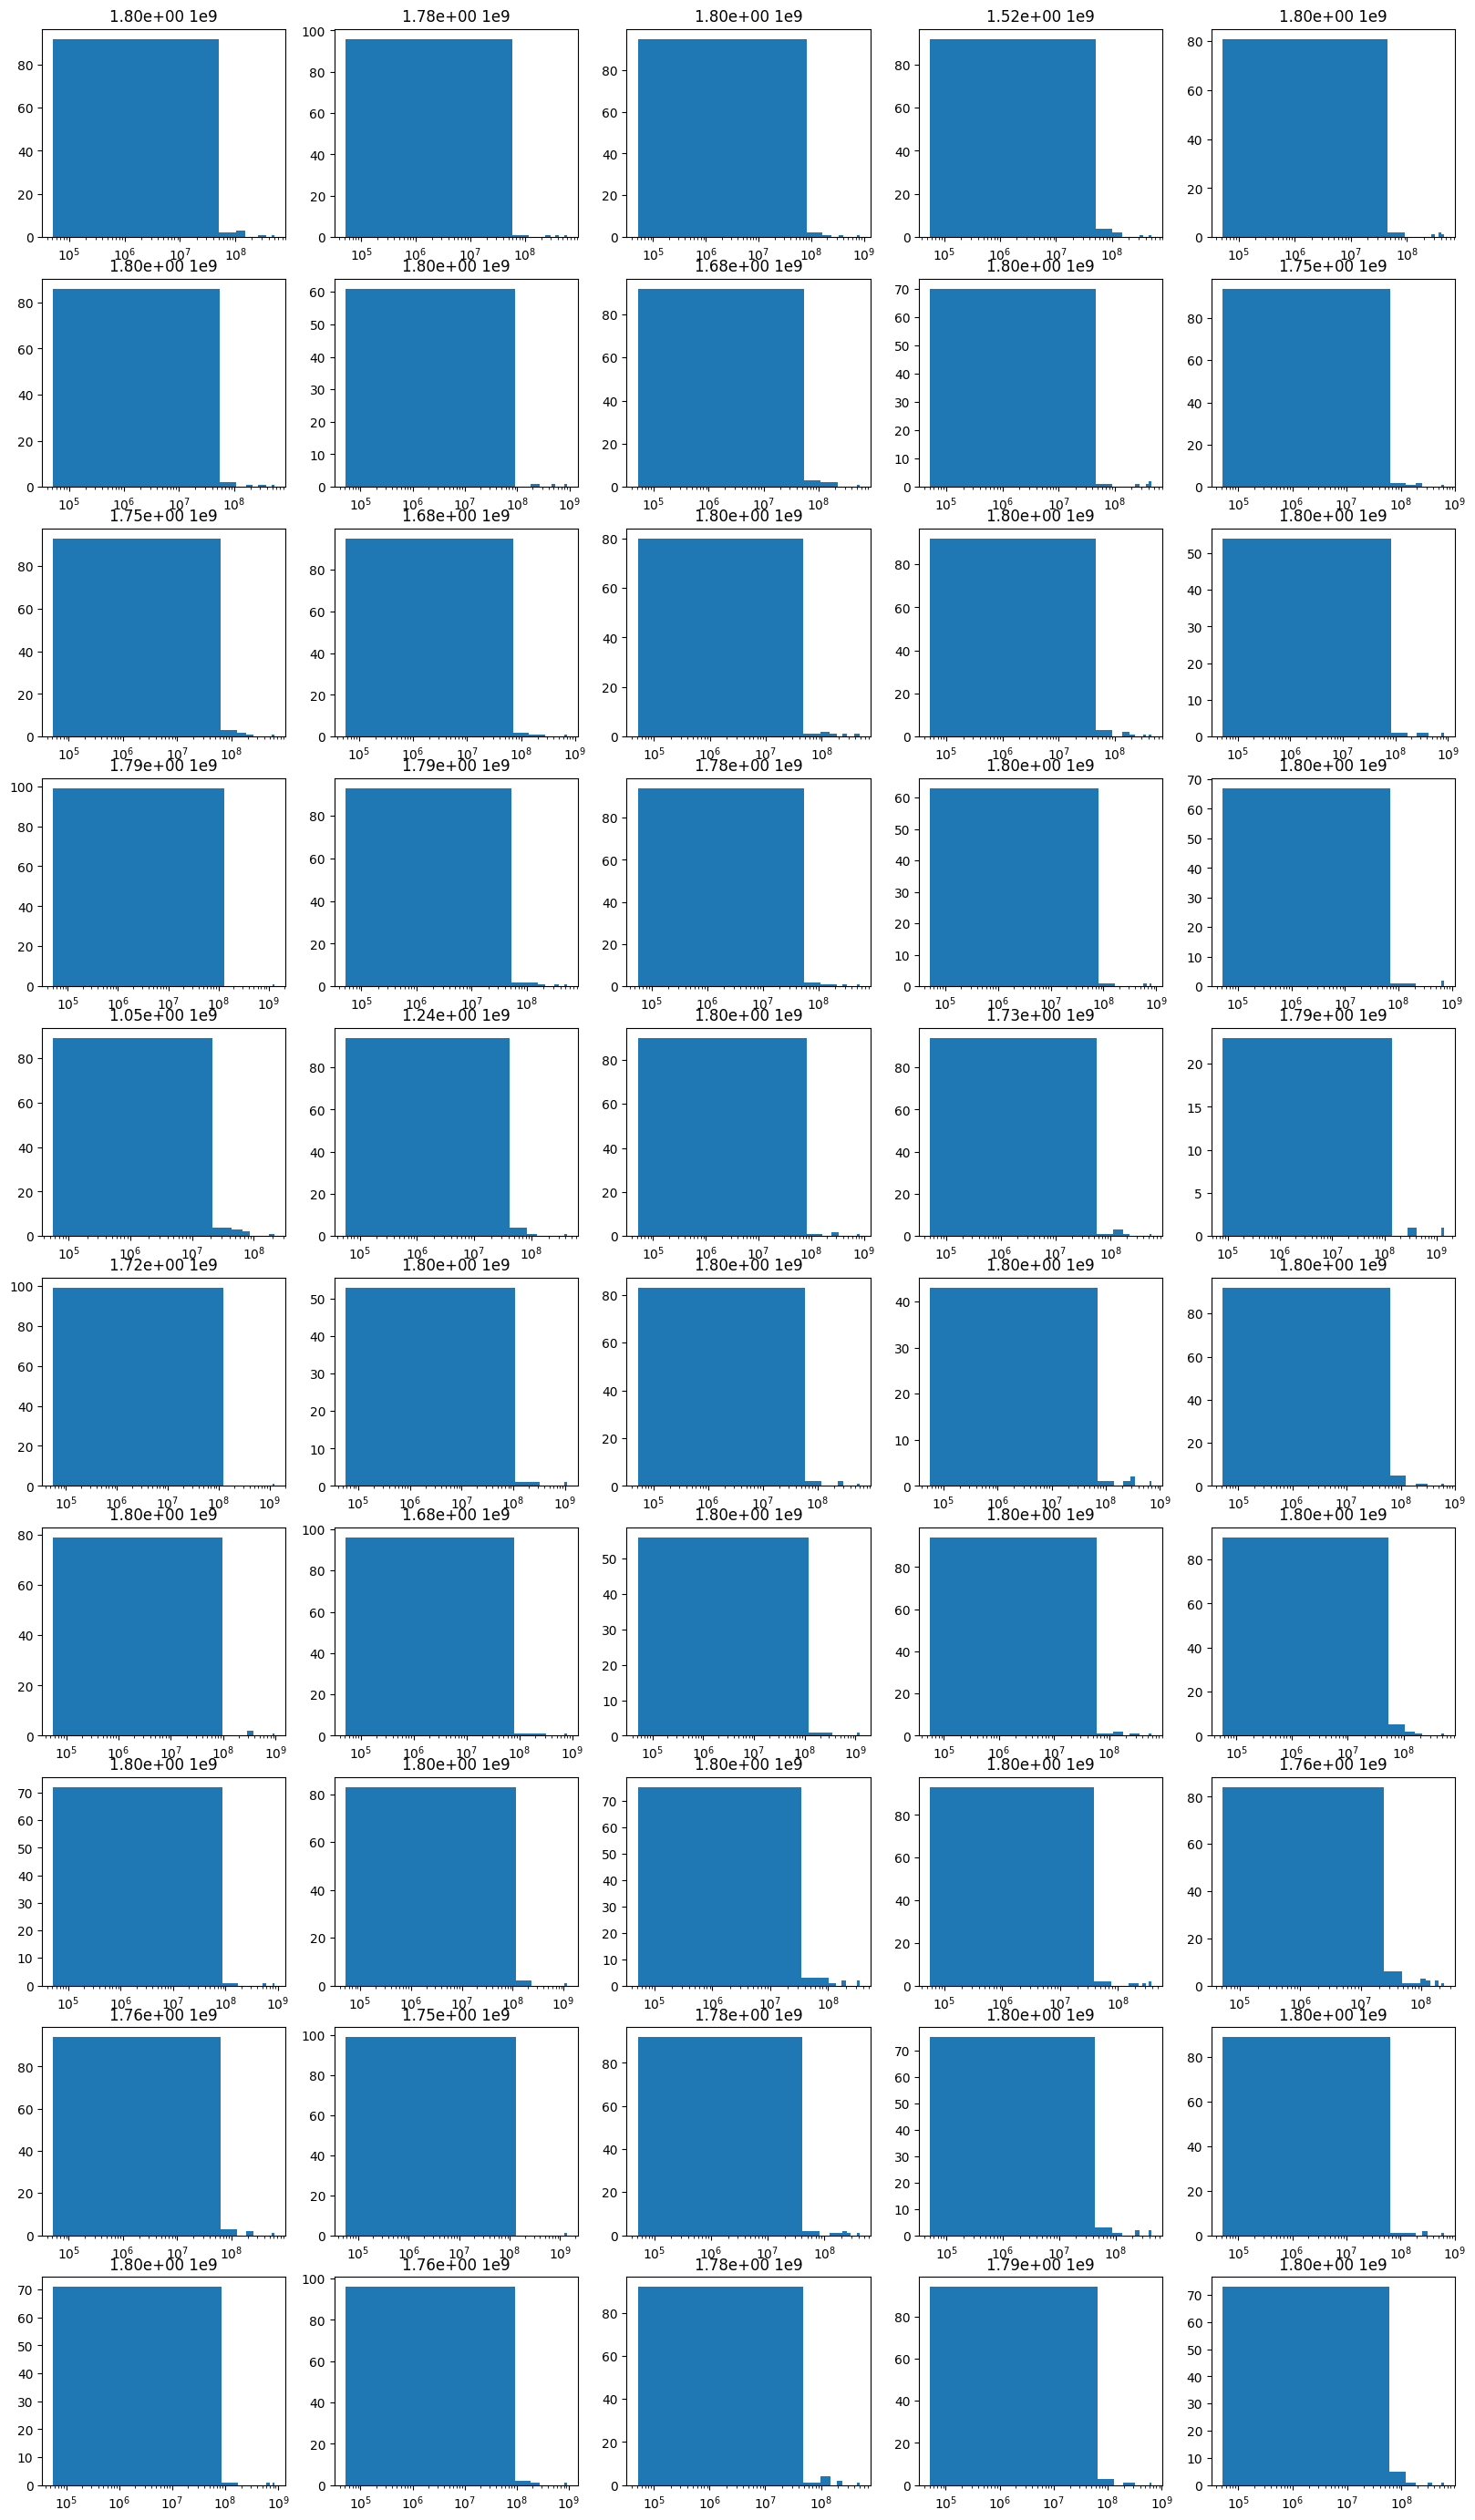

In [154]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.hist(sim_mass_list[i], )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    ax.set_xscale('log')

## Realistic halo, sample, NN and then accreat with NN backward looking

In [7]:
mass_name = data[['star_log10mass', 'Galaxy_name']].drop_duplicates()
mass_name = mass_name[mass_name['star_log10mass']<1.4*1e9]

In [8]:
len(mass_name)

3778

In [5]:
def gen_real_halo(j, mass_nn, data):
    np.random.seed(j)
    
    N=3
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)
    M_tot = 1.8 * 1e9
    samples = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > data_mass.max():
            analictical_sample = inverse_cdf(np.random.rand(1), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - samples[-1]
        else:
            if M_tot < data_mass.min():
                break
            max_u = cdf(M_tot, alpha)
            analictical_sample = inverse_cdf(np.random.uniform(0, max_u), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - samples[-1]
        iteration += 1 
        
    samples =  np.array(samples)
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in samples ])
    hist = np.sum( arr, axis=0)
    return hist, samples

In [8]:

mass_nn = data_mass.values.reshape(-1, 1)
with Pool(processes=cpu_count()) as p:
    result = p.starmap(gen_real_halo, [[j, mass_nn, data] for j in range(500)]   )

hist_list, sim_mass_list = zip(*result)

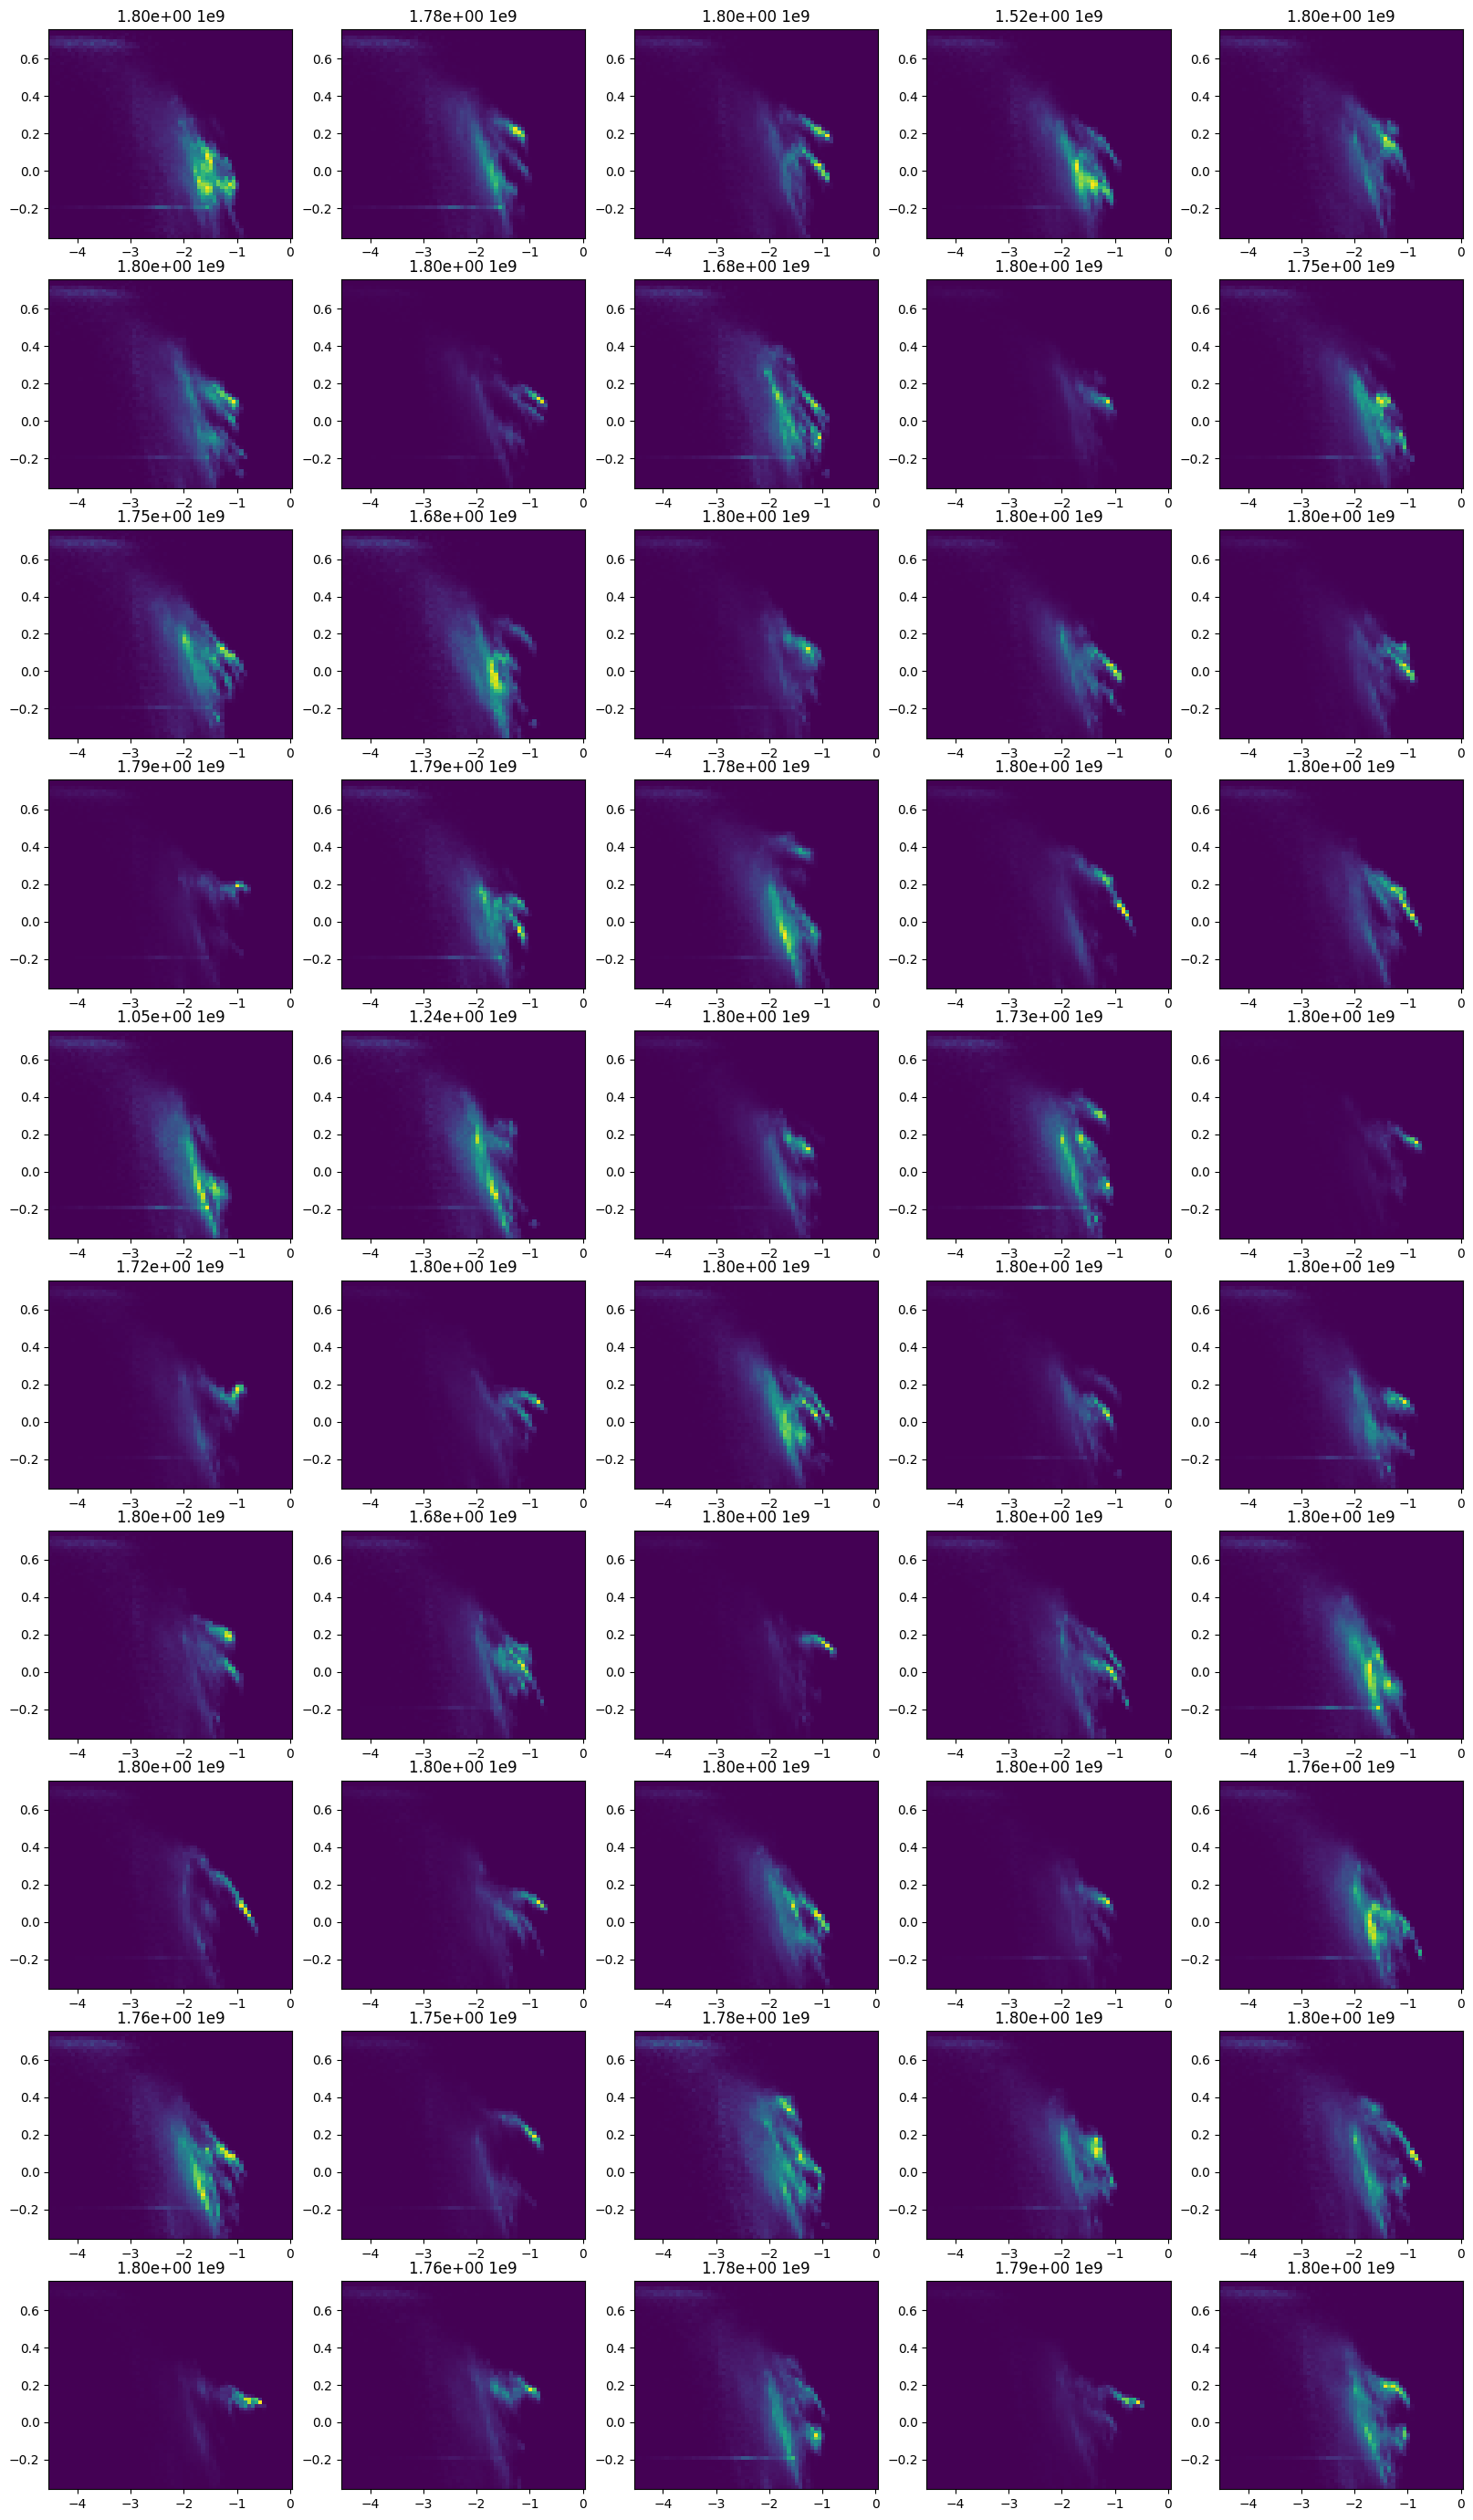

In [191]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower',extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    

# Sampling directly the galaxies

3778
51519.293494715705


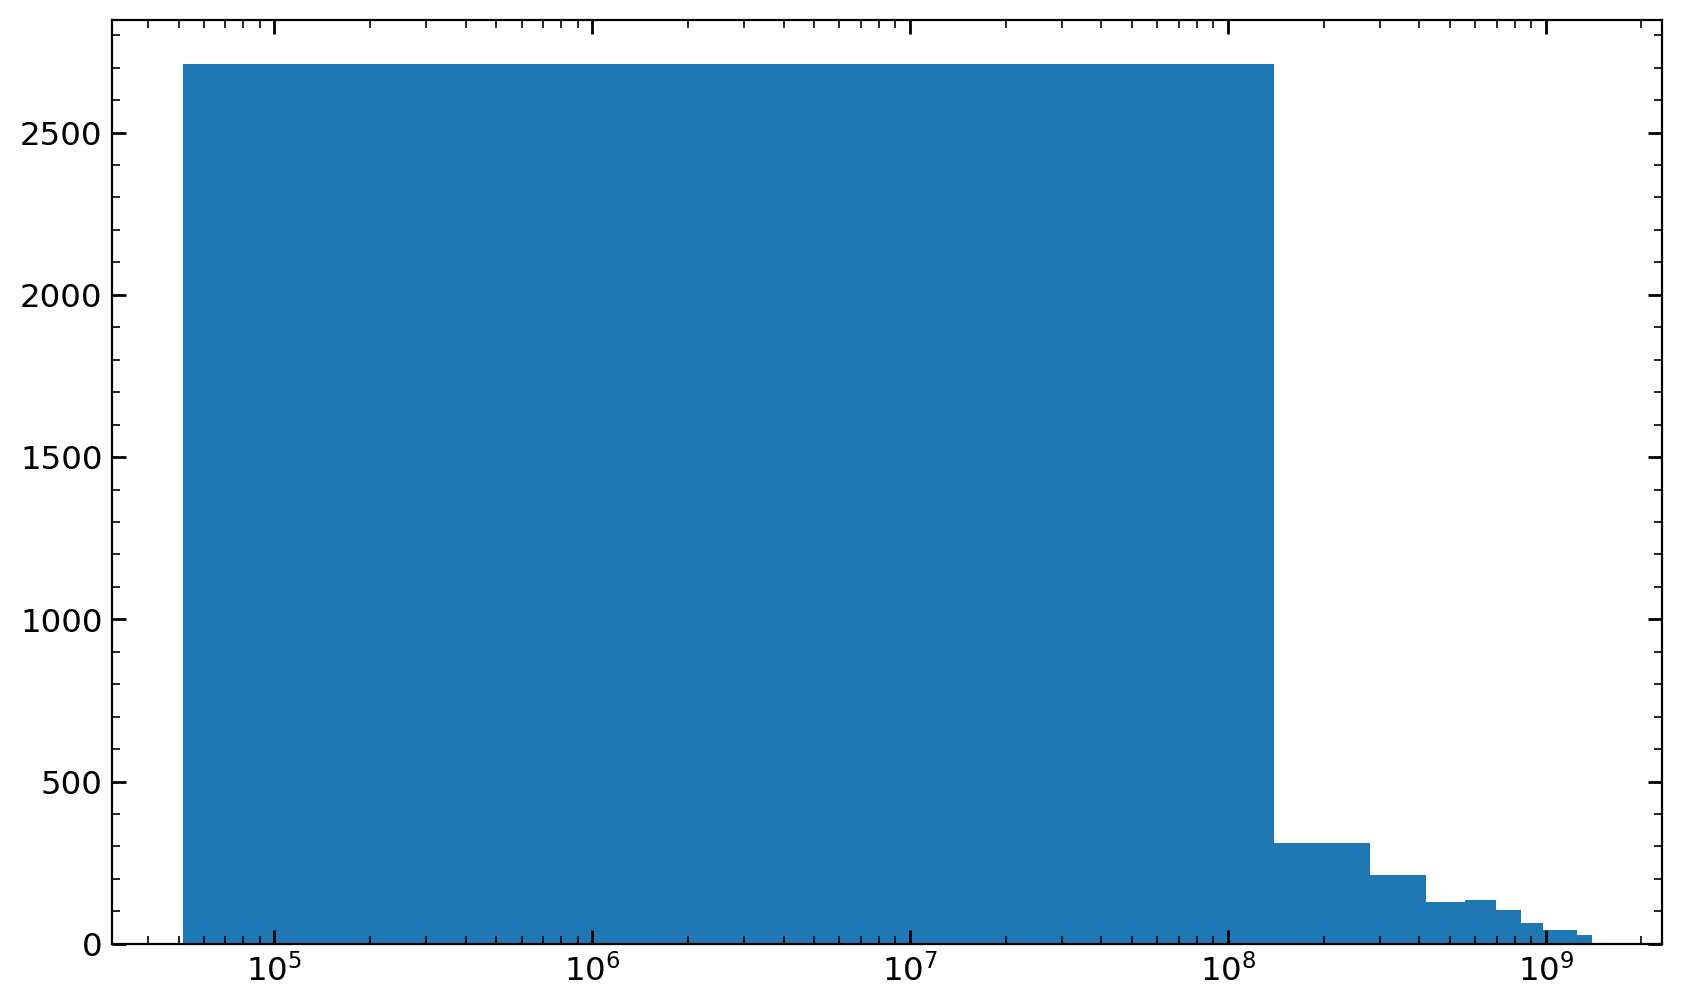

In [2]:
data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
data['star_log10mass'] = 10**data['star_log10mass']
data_mass = data['star_log10mass'].drop_duplicates()
data_mass = data_mass[data_mass<1.4*1e9]
print(len(data_mass))
print(data_mass.min())
plt.hist(data_mass)
plt.xscale('log')

m_min, m_max = data_mass.min(), data_mass.max()
alpha = 1.25
def pdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* m**(-alpha)
def cdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* (1/(1-alpha)) * (m**(1-alpha) - m_min**(1-alpha))

def inverse_cdf(y, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (y*norm_const*(1-alpha) + m_min**(1-alpha))**(1/(1-alpha))

In [3]:
def gen_real_halo(j, galaxy_name, mass_nn, infall_time):
    np.random.seed(j)
    N=3
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)
    M_tot = 1.8 * 1e9
    samples = []
    masses =  []
    times = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > mass_nn.max():
            analictical_sample = inverse_cdf(np.random.rand(1), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = galaxy_name[indices[0]][0][0]
            mass_sample = mass_nn[indices[0]][0][0]
            time_sample = infall_time[indices[0]][0][0]
            if sample in samples:
                sample = galaxy_name[indices[0]][1][0]
                mass_sample = mass_nn[indices[0]][1][0]
                time_sample = infall_time[indices[0]][1][0]
                if sample in samples:
                    sample = galaxy_name[indices[0]][2][0]
                    mass_sample = mass_nn[indices[0]][2][0]
                    time_sample = infall_time[indices[0]][2][0]
                    samples.append(sample)
                    masses.append(mass_sample)
                    times.append(time_sample)
                else:
                    samples.append(sample)
                    masses.append(mass_sample)
                    times.append(time_sample)
            else:
                samples.append(sample)
                masses.append(mass_sample)
                times.append(time_sample)
            M_tot = M_tot - mass_sample
        else:
            if M_tot < mass_nn.min():
                break
            max_u = cdf(M_tot, alpha)
            analictical_sample = inverse_cdf(np.random.uniform(0, max_u), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = galaxy_name[indices[0]][0][0]
            mass_sample = mass_nn[indices[0]][0][0]
            time_sample = infall_time[indices[0]][0][0]
            if sample in samples:
                sample = galaxy_name[indices[0]][1][0]
                mass_sample = mass_nn[indices[0]][1][0]
                time_sample = infall_time[indices[0]][1][0]
                if sample in samples:
                    sample = galaxy_name[indices[0]][2][0]
                    mass_sample = mass_nn[indices[0]][2][0]
                    time_sample = infall_time[indices[0]][2][0]
                    samples.append(sample)
                    masses.append(mass_sample)
                    times.append(time_sample)
                else:
                    samples.append(sample)
                    masses.append(mass_sample)
                    times.append(time_sample)
            else:
                samples.append(sample)
                masses.append(mass_sample)
                times.append(time_sample)
            M_tot = M_tot - mass_sample
        iteration += 1 
        
    samples =  np.array(samples)
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{s}'+'.npz' )['observables']  for s in samples ])
    # hist = np.expand_dims(np.log10(np.sum( arr, axis=0) + 1e-6 +1), axis=0)
    # hist = np.expand_dims(np.log10(arr + 1e-6 +1), axis=0)
    hist_0 = np.sum( arr, axis=0)
    hist_to_return = [np.stack([hist_0, np.ones_like(hist_0)*i]) for i in range(samples.shape[0])]  #nasty trick to allow to save both the N_th number and the histogram in the same array
    
    masses = np.array(masses)
    infall_time = np.array(infall_time)
    indices = np.argsort(masses)[::-1] #sort the masses in descending order
    
    #reorder masses and infall time
    masses = masses[indices]
    infall_time = infall_time[indices]
    samples = samples[indices]
    
    return hist_to_return, np.column_stack([masses, infall_time]), np.array([samples for i in range(samples.shape[0])]) # I want for each of the hist to have all the names of the galaxies that contributed to it, I cannot flatten it 

In [4]:
mass_name = data[['star_log10mass', 'Galaxy_name', 'infall_time']].drop_duplicates()
mass_name = mass_name[mass_name['star_log10mass']<1.4*1e9]
min_feh, max_feh = data['feh'].min(), data['feh'].max() 
min_ofe, max_ofe = data['ofe'].min(), data['ofe'].max()

In [35]:
mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
infall_time = mass_name['infall_time'].values.reshape(-1, 1)
galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)
with Pool(processes=cpu_count()) as p:
    result = p.starmap(gen_real_halo, [[j, galaxy_name, mass_nn, infall_time] for j in range(100)]   )

hist_list, params_list, galaxy_list = zip(*result)
flattened_hist_list = [item for sublist in hist_list for item in sublist]
flattened_param_list = [item for sublist in params_list for item in sublist]

flattened_hist_list =  np.array(flattened_hist_list)
flattened_param_list =  np.array(flattened_param_list)

In [6]:
print(f'there are {len(galaxy_list)} original histogram, each of them is composed a different number of galaxies and theri name can be accessed by galaxy_list[i] ')

there are 1000 original histogram, each of them is composed a different number of galaxies and theri name can be accessed by galaxy_list[i] 


In [36]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x_0 = x[:, :1, :, :] #the :1 keeps the channel dimension
        N =  x[:, 1:, 0, 0]
        
        out = self.conv_layers(x_0)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return torch.cat((out, N), axis=1)

device = 'cuda'

# instantiate a CNN embedding network
embedding_net =  ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=10,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=10,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=10,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=100, num_transforms=10,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 1024,
    'learning_rate': 5e-5,
    'stop_after_epochs': 20
}

conditions  = mass_name[['star_log10mass', 'infall_time']]
minimum_theta = [conditions[col].values.min() for col in conditions.columns]   
maximum_theta = [conditions[col].values.max() for col in conditions.columns]       
prior = ili.utils.Uniform(low=minimum_theta, high=maximum_theta, device=device)

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

### first test without the np.log10

In [14]:
x_0 = torch.from_numpy(flattened_hist_list[:100]).float()
theta_0 = torch.from_numpy(flattened_param_list[:100]).float()

x = torch.from_numpy(flattened_hist_list[100:]).float()
theta = torch.from_numpy(flattened_param_list[100:]).float()

loader = NumpyLoader(x=x, theta=theta)
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)


INFO:root:MODEL INFERENCE CLASS: NPE
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 4.


 Neural network successfully converged after 402 epochs.

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 2 / 4.
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:435: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cpu' vs embedding_net weights have device 'cuda:0'. Automatically switching the embedding_net's device to 'cpu', which could otherwise be done manually using the line `embedding_net.to('cpu')`.
  warnings.warn(


 Neural network successfully converged after 505 epochs.

INFO:root:Training model 3 / 4.


 Neural network successfully converged after 222 epochs.

INFO:root:Training model 4 / 4.


 Neural network successfully converged after 62 epochs.

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 18304.40305876732 seconds to train models.


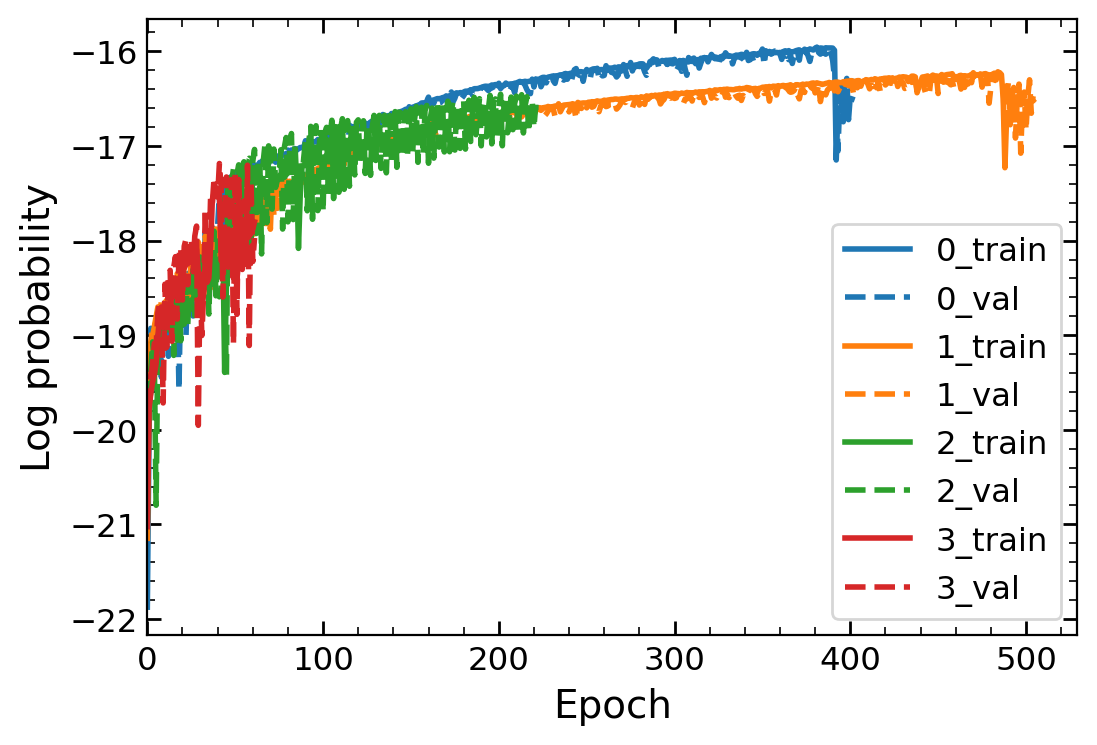

In [15]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 3646 posterior samples:   0%|          | 0/3646 [00:00<?, ?it/s]

Drawing 2898 posterior samples:   0%|          | 0/2898 [00:00<?, ?it/s]

Drawing 2334 posterior samples:   0%|          | 0/2334 [00:00<?, ?it/s]

Drawing 1122 posterior samples:   0%|          | 0/1122 [00:00<?, ?it/s]

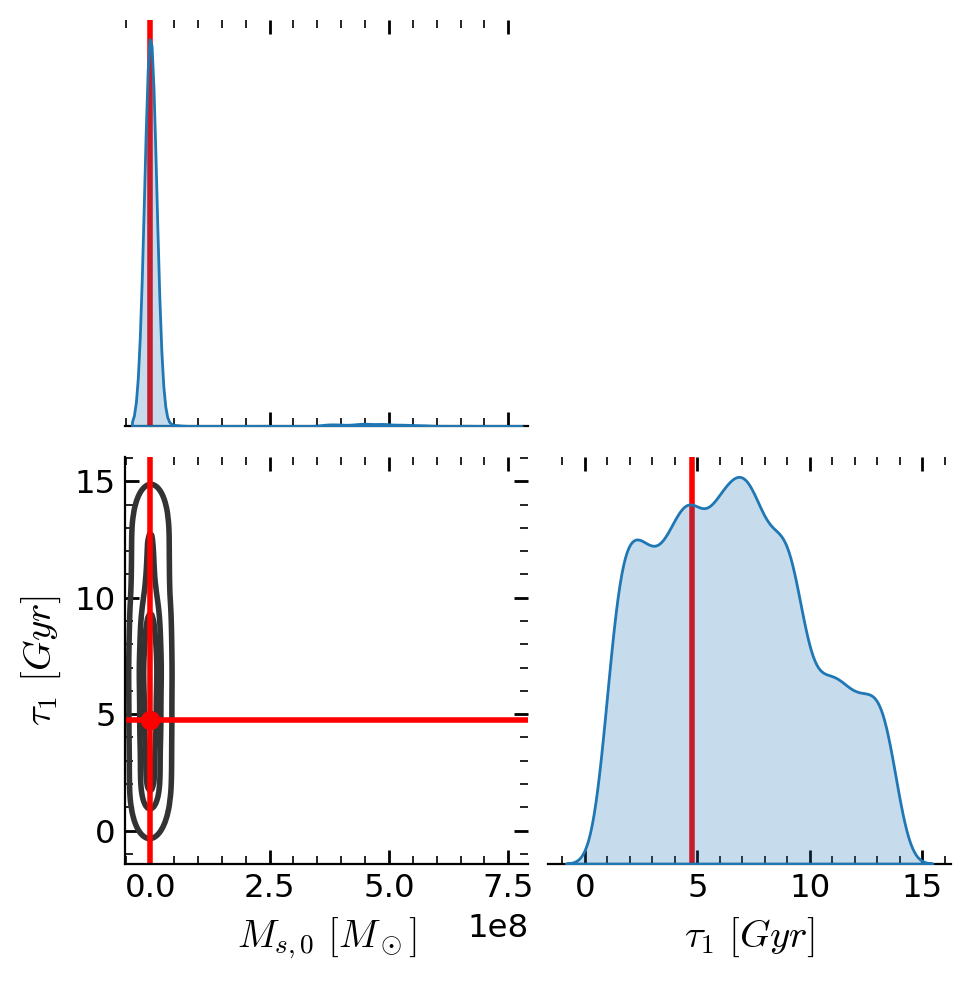

In [24]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = [r'$M_{s}\ [M_\odot]$', r'$\tau \ [Gyr]$'],
    out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_0[99], theta_fid=theta_0[99],
)

Drawing 3735 posterior samples:   0%|          | 0/3735 [00:00<?, ?it/s]

Drawing 2939 posterior samples:   0%|          | 0/2939 [00:00<?, ?it/s]

Drawing 2290 posterior samples:   0%|          | 0/2290 [00:00<?, ?it/s]

Drawing 1036 posterior samples:   0%|          | 0/1036 [00:00<?, ?it/s]

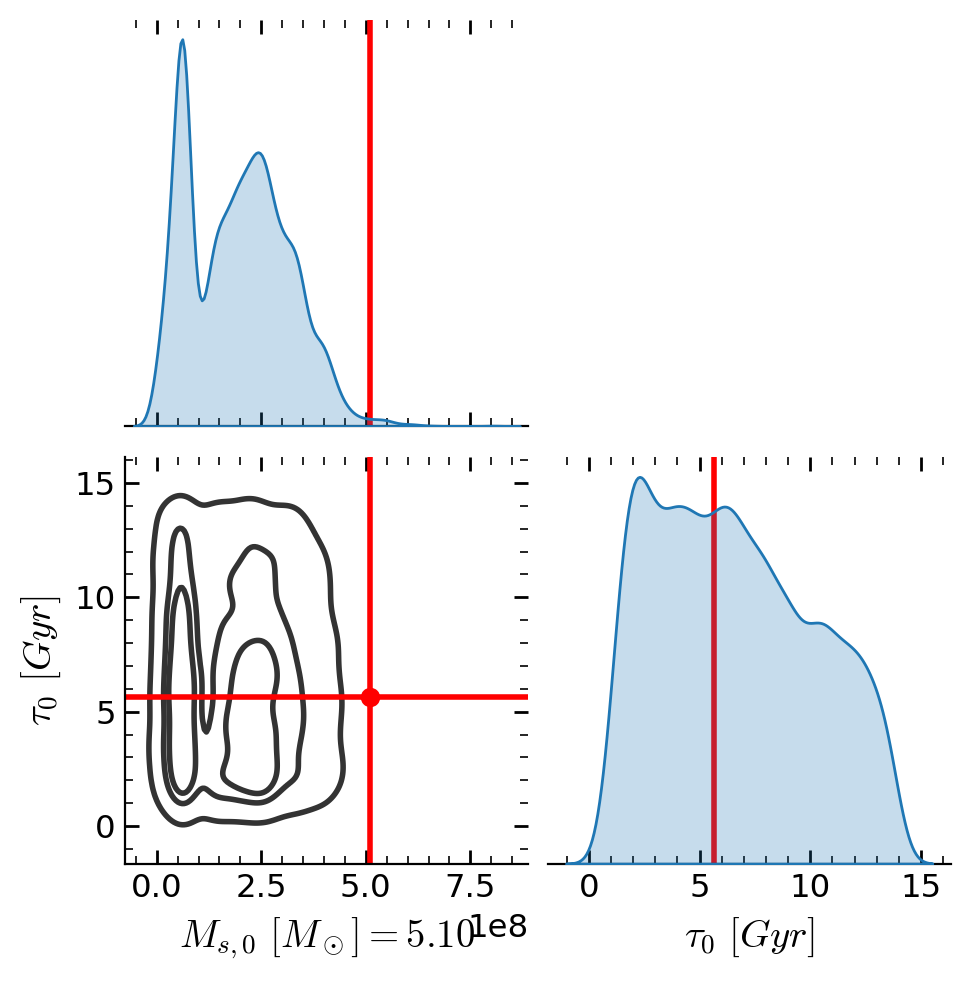

Drawing 3823 posterior samples:   0%|          | 0/3823 [00:00<?, ?it/s]

Drawing 2813 posterior samples:   0%|          | 0/2813 [00:00<?, ?it/s]

Drawing 2223 posterior samples:   0%|          | 0/2223 [00:00<?, ?it/s]

Drawing 1141 posterior samples:   0%|          | 0/1141 [00:00<?, ?it/s]

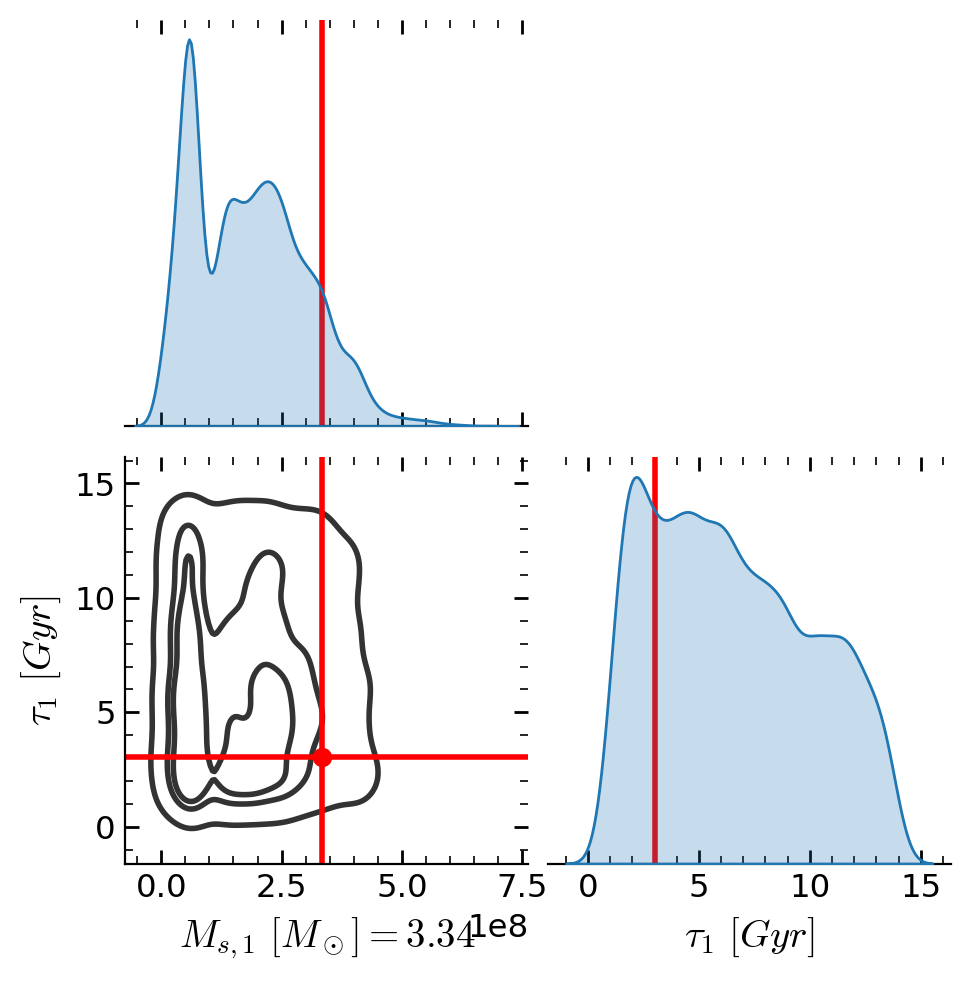

Drawing 3677 posterior samples:   0%|          | 0/3677 [00:00<?, ?it/s]

Drawing 2912 posterior samples:   0%|          | 0/2912 [00:00<?, ?it/s]

Drawing 2273 posterior samples:   0%|          | 0/2273 [00:00<?, ?it/s]

Drawing 1138 posterior samples:   0%|          | 0/1138 [00:00<?, ?it/s]

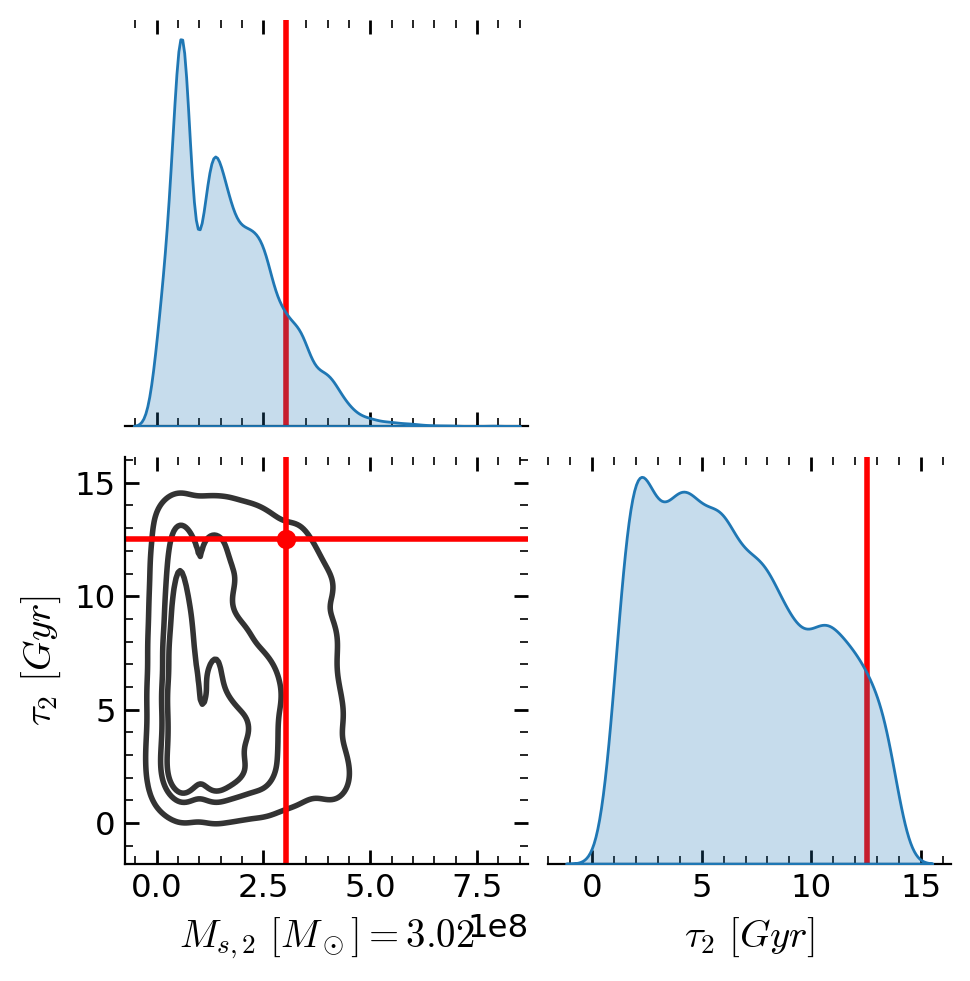

Drawing 3755 posterior samples:   0%|          | 0/3755 [00:00<?, ?it/s]

Drawing 2956 posterior samples:   0%|          | 0/2956 [00:00<?, ?it/s]

Drawing 2238 posterior samples:   0%|          | 0/2238 [00:00<?, ?it/s]

Drawing 1051 posterior samples:   0%|          | 0/1051 [00:00<?, ?it/s]

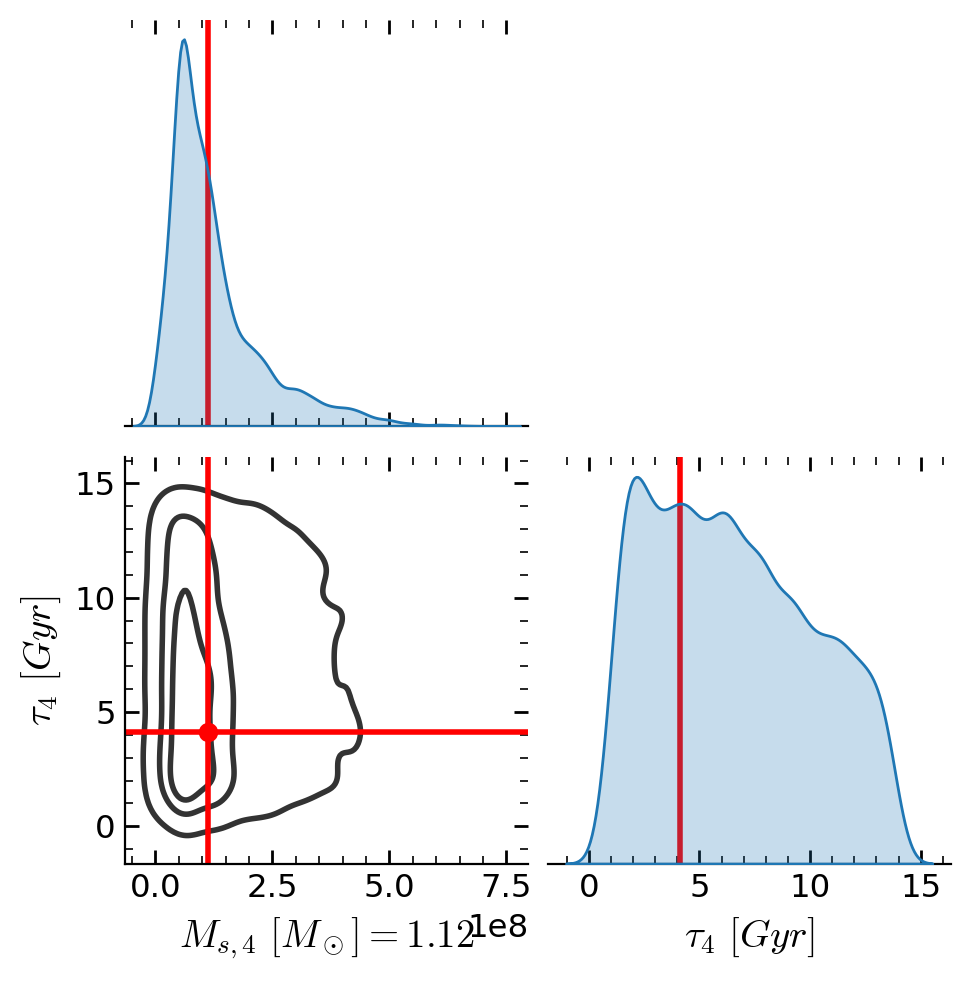

Drawing 3811 posterior samples:   0%|          | 0/3811 [00:00<?, ?it/s]

Drawing 2856 posterior samples:   0%|          | 0/2856 [00:00<?, ?it/s]

Drawing 2225 posterior samples:   0%|          | 0/2225 [00:00<?, ?it/s]

Drawing 1108 posterior samples:   0%|          | 0/1108 [00:00<?, ?it/s]

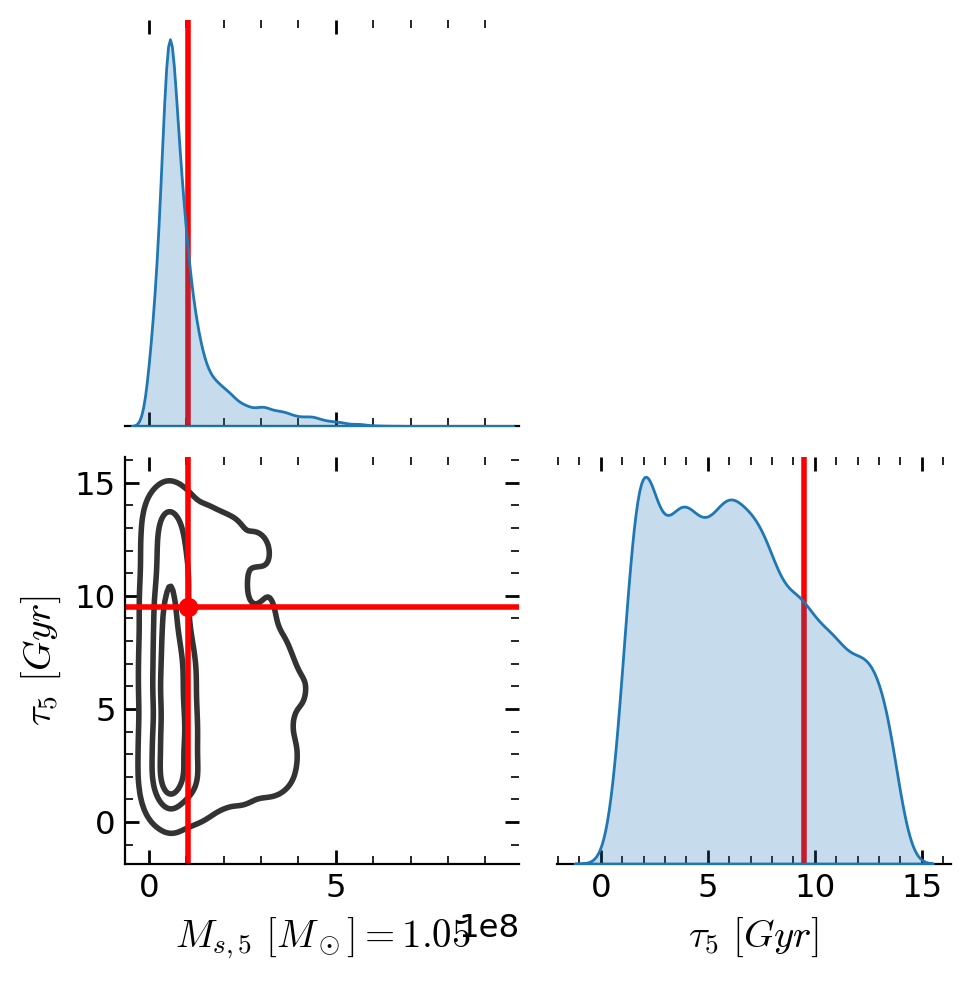

Drawing 3744 posterior samples:   0%|          | 0/3744 [00:00<?, ?it/s]

Drawing 2842 posterior samples:   0%|          | 0/2842 [00:00<?, ?it/s]

Drawing 2335 posterior samples:   0%|          | 0/2335 [00:00<?, ?it/s]

Drawing 1079 posterior samples:   0%|          | 0/1079 [00:00<?, ?it/s]

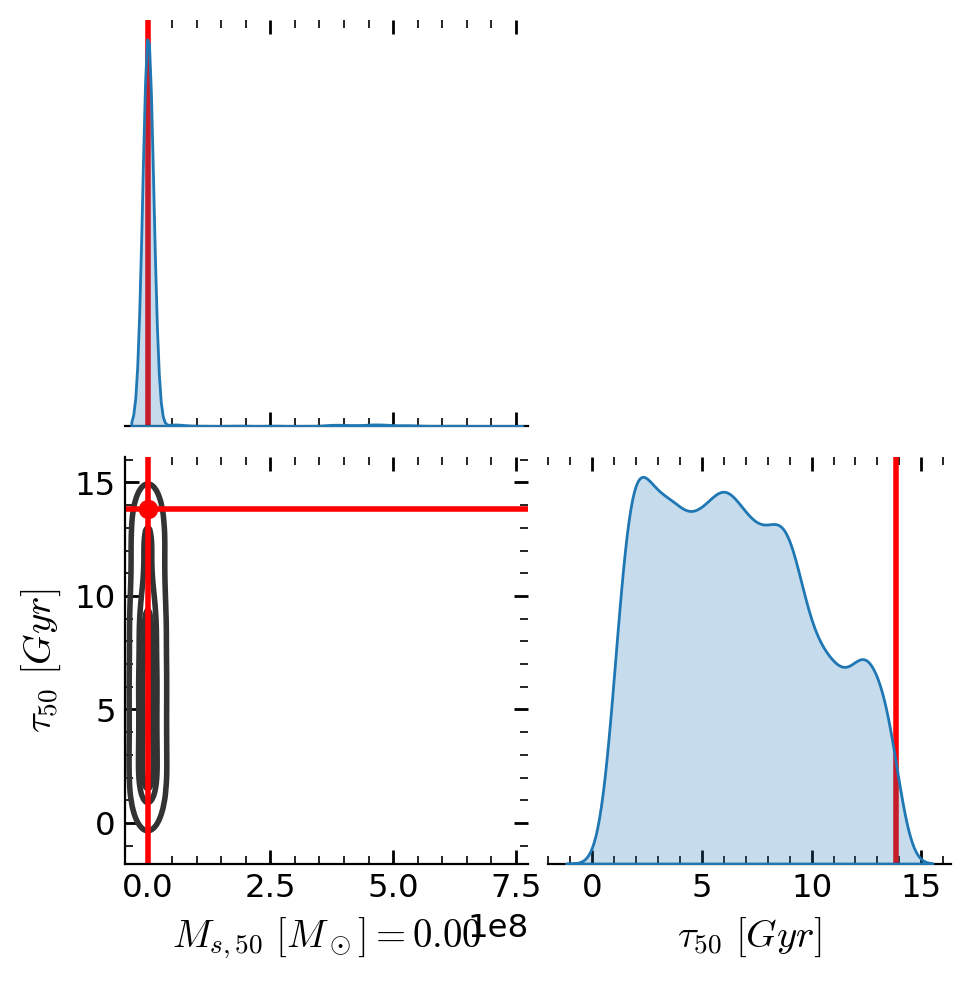

Drawing 3762 posterior samples:   0%|          | 0/3762 [00:00<?, ?it/s]

Drawing 2909 posterior samples:   0%|          | 0/2909 [00:00<?, ?it/s]

Drawing 2266 posterior samples:   0%|          | 0/2266 [00:00<?, ?it/s]

Drawing 1063 posterior samples:   0%|          | 0/1063 [00:00<?, ?it/s]

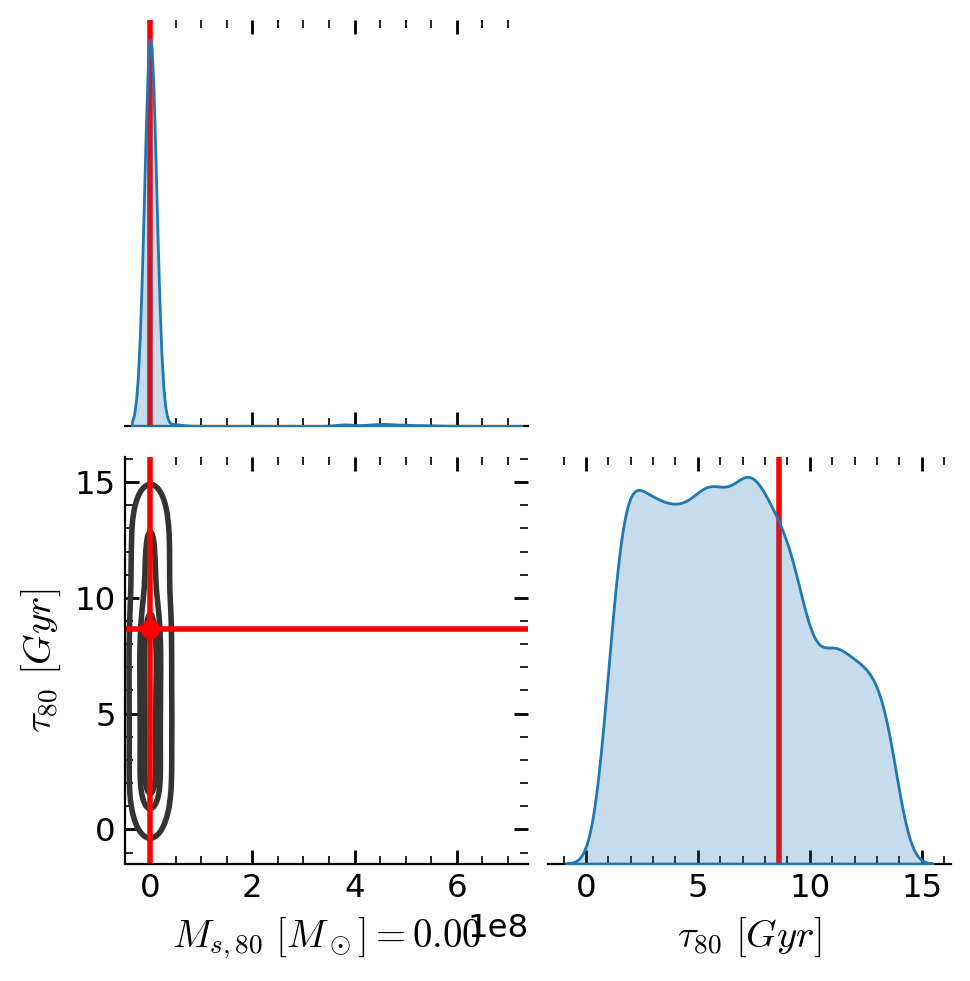

Drawing 3713 posterior samples:   0%|          | 0/3713 [00:00<?, ?it/s]

Drawing 2879 posterior samples:   0%|          | 0/2879 [00:00<?, ?it/s]

Drawing 2264 posterior samples:   0%|          | 0/2264 [00:00<?, ?it/s]

Drawing 1144 posterior samples:   0%|          | 0/1144 [00:00<?, ?it/s]

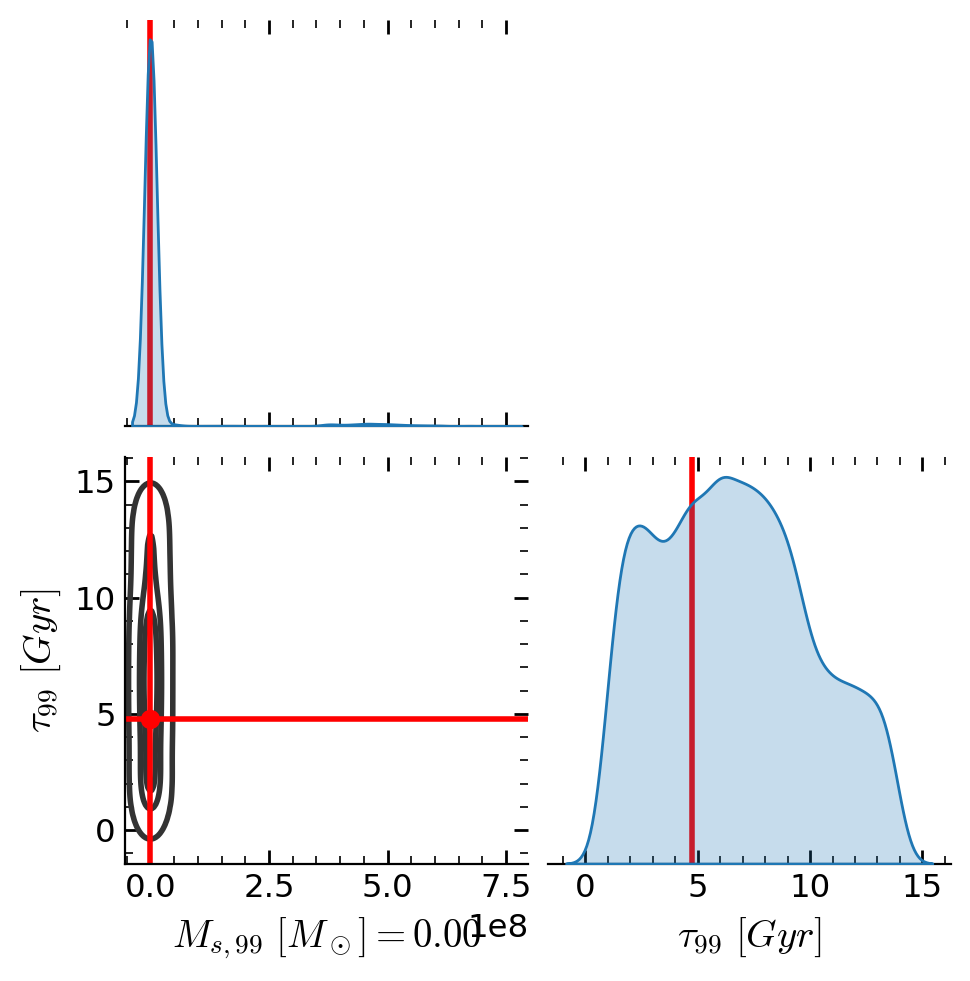

In [33]:
for i in [0, 1, 2, 4, 5, 50, 80, 99]:
    metric = PlotSinglePosterior(
        num_samples=10_000, sample_method='direct', 
        labels = [rf'$M_{{s, {i}}}\ [M_\odot] = {theta_0[i][0].item()/1e8:.2f}$', rf'$\tau_{{{i}}}\ [Gyr]$'],
        out_dir=None
    )
    fig = metric(
        posterior=posterior_ensemble,
        x_obs = x_0[i], theta_fid=theta_0[i],
    )
    plt.show()

100%|██████████| 100/100 [00:01<00:00, 55.65it/s]


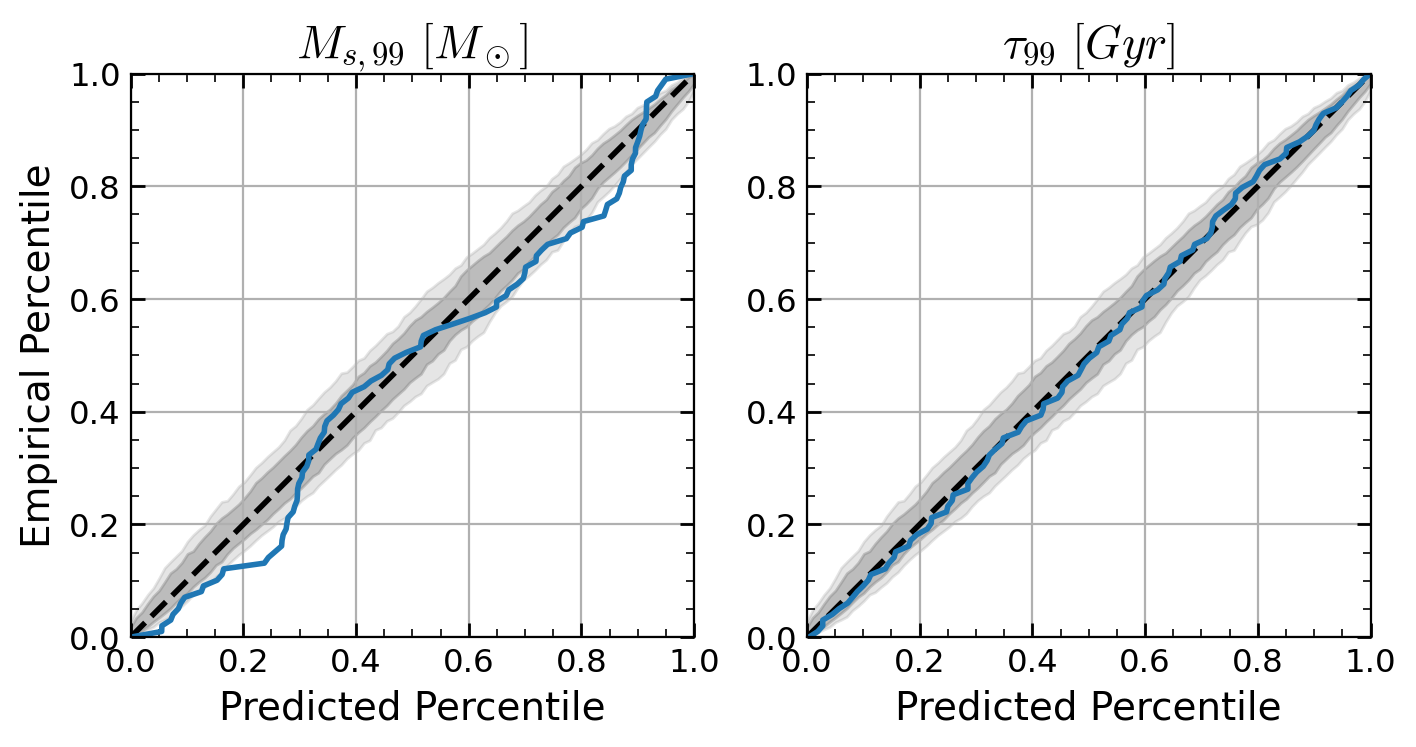

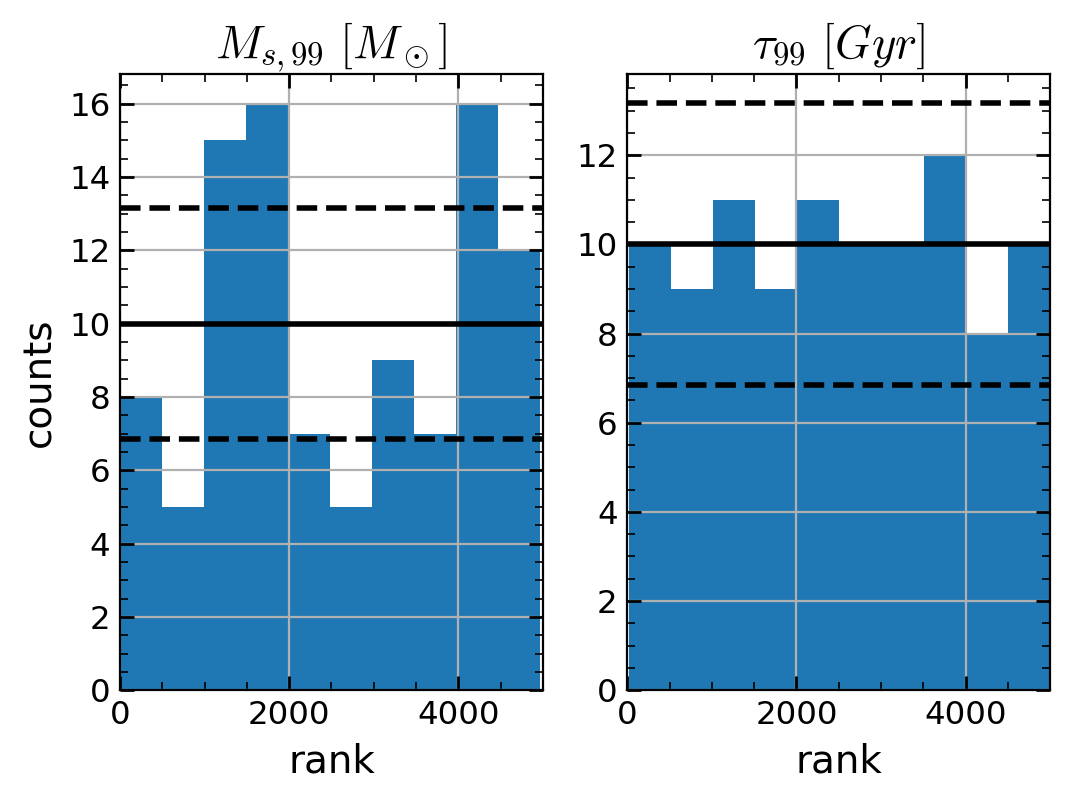

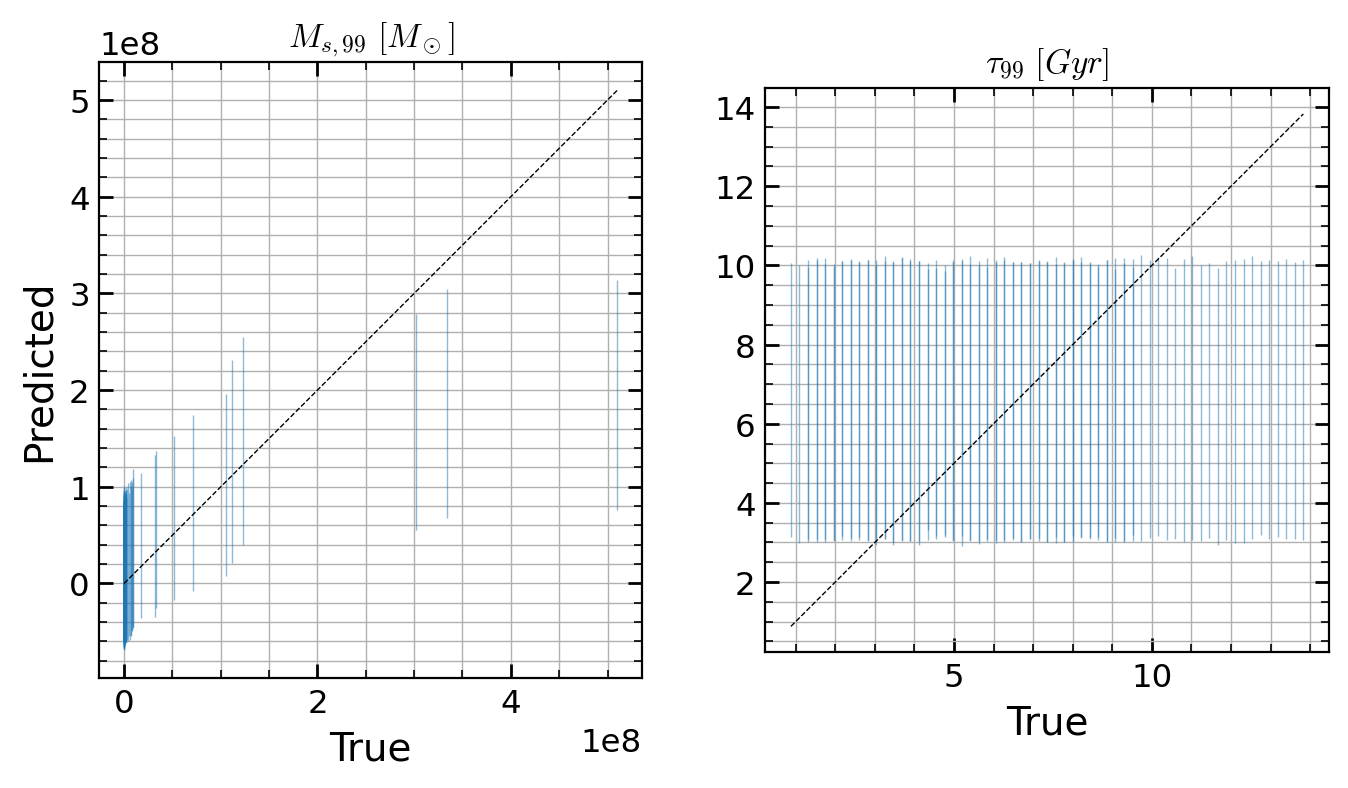

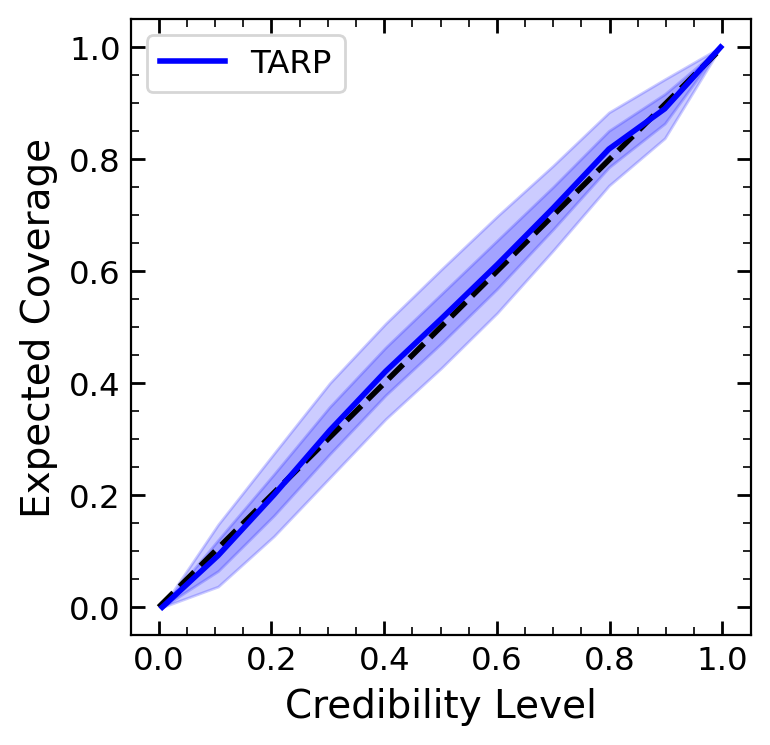

In [34]:
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=[rf'$M_{{s}}\ [M_\odot]$', rf'$\tau [Gyr]$'], plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior_ensemble,
    x=x_0, theta=theta_0
)

### second test with the np.log10 and less possible galaxy (100 original galaxy)

In [45]:
array_to_scale = np.zeros_like(flattened_hist_list)
array_to_scale[:, 0, :, :] += 1+ 1e-6

In [46]:
array_to_scale[1005]

array([[[1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001],
        [1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001],
        [1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001],
        ...,
        [1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001],
        [1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001],
        [1.000001, 1.000001, 1.000001, ..., 1.000001, 1.000001,
         1.000001]],

       [[0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        ...,
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.  

In [50]:
x_0[0]

tensor([[[4.3429e-07, 4.3429e-07, 4.3429e-07,  ..., 1.9685e+00,
          1.1139e+00, 9.5424e-01],
         [4.3429e-07, 4.3429e-07, 4.3429e-07,  ..., 2.0755e+00,
          1.1761e+00, 1.0414e+00],
         [4.7712e-01, 4.3429e-07, 3.0103e-01,  ..., 2.2122e+00,
          6.0206e-01, 3.0103e-01],
         ...,
         [4.3429e-07, 4.3429e-07, 4.3429e-07,  ..., 4.3429e-07,
          4.3429e-07, 4.3429e-07],
         [4.3429e-07, 4.3429e-07, 4.3429e-07,  ..., 4.3429e-07,
          4.3429e-07, 4.3429e-07],
         [4.3429e-07, 4.3429e-07, 4.3429e-07,  ..., 4.3429e-07,
          4.3429e-07, 4.3429e-07]],

        [[      -inf,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [      -inf,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         [      -inf,       -inf,       -inf,  ...,       -inf,
                -inf,       -inf],
         ...,
         [      -inf,       -inf,       -inf,  ...,       -inf,
               

In [48]:
flattened_hist_list[:, 0, :, :] = np.log10(flattened_hist_list[:, 0, :, :] + 1+ 1e-6)

x_0 = torch.from_numpy(np.log10(flattened_hist_list[:100])).float()
theta_0 = torch.from_numpy(flattened_param_list[:100]).float()

x = torch.from_numpy(np.log(flattened_hist_list[100:]) ).float()
theta = torch.from_numpy(flattened_param_list[100:]).float()

loader = NumpyLoader(x=x, theta=theta)
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

/tmp/ipykernel_3979559/1823549373.py:3: RuntimeWarning: divide by zero encountered in log10
  x_0 = torch.from_numpy(np.log10(flattened_hist_list[:100])).float()
/tmp/ipykernel_3979559/1823549373.py:6: RuntimeWarning: divide by zero encountered in log
  x = torch.from_numpy(np.log(flattened_hist_list[100:]) ).float()
INFO:root:MODEL INFERENCE CLASS: NPE
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 4.
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:435: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device

 Training neural network. Epochs trained: 16

KeyboardInterrupt: 